#  Analyse spectra ADR holo at AuxTel for Configuration PSF2DFFM

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 27th  2022
- last update : June 27th 2022

- **kernel anaconda3_auxtel** at CC or **python 3** locally


## ANalyse ADR subtraction

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

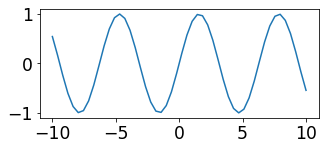

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-27'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [66]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor, dumpParameters, FullForwardModelFitWorkspace,  run_ffm_minimisation, plot_comparison_truth
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

In [15]:
import pickle

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220317"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,'auxtel_config_holo_DECONVOLUTION_PSF2D.ini','auxtel_config_holo_DECONVOLUTION_FFM.ini','auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini']
config_idx = 3
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_PSF2DFFM'

In [24]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [25]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'PSF2DFFM'

# Path

In [27]:
HOSTCC=True

In [28]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
    path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)


In [29]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317'

In [30]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Jun 10 13:05 2022031700237
drwxrws--- 1 dagoret lsst 2 Jun 10 16:03 2022031700244
drwxrws--- 1 dagoret lsst 2 Jun 10 12:04 2022031700245
drwxrws--- 1 dagoret lsst 2 Jun 10 21:50 2022031700252
drwxrws--- 1 dagoret lsst 2 Jun 10 11:41 2022031700258
drwxrws--- 1 dagoret lsst 2 Jun 10 12:56 2022031700259
drwxrws--- 1 dagoret lsst 2 Jun 10 12:11 2022031700266
drwxrws--- 1 dagoret lsst 2 Jun 10 12:25 2022031700272
drwxrws--- 1 dagoret lsst 2 Jun 10 12:39 2022031700273
drwxrws--- 1 dagoret lsst 2 Jun 10 12:03 2022031700279
drwxrws--- 1 dagoret lsst 2 Jun 10 14:13 2022031700280
drwxrws--- 1 dagoret lsst 2 Jun 10 13:25 2022031700286
drwxrws--- 1 dagoret lsst 2 Jun 10 13:22 2022031700287
drwxrws--- 1 dagoret lsst 2 Jun 10 12:35 2022031700293
drwxrws--- 1 dagoret lsst 2 Jun 10 12:40 2022031700300
drwxrws--- 1 dagoret lsst 2 Jun 10 13:03 2022031700301
drwxrws--- 1 dagoret lsst 2 Jun 10 13:05 2022031700309
drwxrws--- 1 dagoret lsst 2 Jun 10 15:29 2022031700310
dr

In [31]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini


In [32]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [33]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [34]:
df=pd.read_csv(filename_logbook,index_col=0)

In [35]:
pd.set_option('display.max_rows', None)

In [36]:
df

index                     date  \
0       0  2022-03-18T00:51:03.112   
1       1  2022-03-18T00:51:36.190   
2       2  2022-03-18T00:54:30.463   
3       3  2022-03-18T00:55:03.377   
4       4  2022-03-18T00:58:01.707   
5       5  2022-03-18T00:58:34.835   
6       6  2022-03-18T01:01:32.859   
7       7  2022-03-18T01:02:05.775   
8       8  2022-03-18T01:05:03.839   
9       9  2022-03-18T01:05:36.766   
10     10  2022-03-18T01:08:32.232   
11     11  2022-03-18T01:09:05.133   
12     12  2022-03-18T01:12:00.164   
13     13  2022-03-18T01:12:33.079   
14     14  2022-03-18T01:15:32.735   
15     15  2022-03-18T01:16:05.627   
16     16  2022-03-18T01:18:59.663   
17     17  2022-03-18T01:19:32.577   
18     18  2022-03-18T01:22:30.386   
19     19  2022-03-18T01:23:03.286   
20     20  2022-03-18T01:43:39.078   
21     21  2022-03-18T01:44:11.982   
22     22  2022-03-18T01:47:06.515   
23     23  2022-03-18T01:47:39.407   
24     24  2022-03-18T01:50:33.593   
25     25  2022-03-18T01:51:06.516   
26     26  2022-03-18T01:54:00.883   
27     27  2022-03-18T01:54:33.856   
28     28  2022-03-18T01:57:30.505   
29     29  2022-03-18T01:58:03.446   
30     30  2022-03-18T02:01:00.181   
31     31  2022-03-18T02:01:33.339   
32     32  2022-03-18T02:04:30.946   
33     33  2022-03-18T02:05:03.843   
34     34  2022-03-18T02:08:03.232   
35     35  2022-03-18T02:08:36.262   
36     36  2022-03-18T02:11:34.200   
37     37  2022-03-18T02:12:07.156   
38     38  2022-03-18T02:15:00.952   
39     39  2022-03-18T02:15:33.886   
40     40  2022-03-18T02:33:14.260   
41     41  2022-03-18T02:33:47.167   
42     42  2022-03-18T02:36:45.029   
43     43  2022-03-18T02:37:17.962   
44     44  2022-03-18T02:40:14.985   
45     45  2022-03-18T02:40:47.930   
46     46  2022-03-18T02:43:46.361   
47     47  2022-03-18T02:44:19.255   
48     48  2022-03-18T02:47:16.976   
49     49  2022-03-18T02:47:49.912   
50     50  2022-03-18T02:50:52.460   
51     51  2022-03-18T02:51:25.626   
52     52  2022-03-18T03:08:55.717   
53     53  2022-03-18T03:09:28.629   
54     54  2022-03-18T03:13:08.467   
55     55  2022-03-18T03:13:41.360   
56     56  2022-03-18T03:17:20.920   
57     57  2022-03-18T03:17:53.934   
58     58  2022-03-18T03:21:41.018   
59     59  2022-03-18T03:22:14.022   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
1   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
2   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
3   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
4   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
5   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
6   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
7   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
8   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
9   /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
10  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
11  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
12  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
13  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
14  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
15  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
16  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
17  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
18  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
19  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
20  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
21  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
22  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
23  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
24  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
25  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
26  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
27  /sps/lsst/groups/auxtel/data/2022/empty~holo4_...   
28  /sps/lsst/groups/auxtel/data

## Selection of input files

In [37]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031700237_postisrccd.fits
exposure_2022031700238_postisrccd.fits
exposure_2022031700244_postisrccd.fits
exposure_2022031700245_postisrccd.fits
exposure_2022031700251_postisrccd.fits
exposure_2022031700252_postisrccd.fits
exposure_2022031700258_postisrccd.fits
exposure_2022031700259_postisrccd.fits
exposure_2022031700265_postisrccd.fits
exposure_2022031700266_postisrccd.fits
exposure_2022031700272_postisrccd.fits
exposure_2022031700273_postisrccd.fits
exposure_2022031700279_postisrccd.fits
exposure_2022031700280_postisrccd.fits
exposure_2022031700286_postisrccd.fits
exposure_2022031700287_postisrccd.fits
exposure_2022031700293_postisrccd.fits
exposure_2022031700294_postisrccd.fits
exposure_2022031700300_postisrccd.fits
exposure_2022031700301_postisrccd.fits
exposure_2022031700309_postisrccd.fits
exposure_2022031700310_postisrccd.fits
exposure_2022031700316_postisrccd.fits
exposure_2022031700317_postisrccd.fits
exposure_2022031700323_postisrccd.fits
exposure_2022031700324_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031700237', '2022031700244', '2022031700245', '2022031700252', '2022031700258', '2022031700259', '2022031700266', '2022031700272', '2022031700273', '2022031700279', '2022031700280', '2022031700286', '2022031700287', '2022031700293', '2022031700300', '2022031700301', '2022031700309', '2022031700310', '2022031700316', '2022031700317', '2022031700323', '2022031700324', '2022031700330', '2022031700331', '2022031700337', '2022031700338', '2022031700344', '2022031700345', '2022031700351', '2022031700352', '2022031700358', '2022031700359', '2022031700365', '2022031700366', '2022031700372', '2022031700373', '2022031700379', '2022031700380', '2022031700386', '2022031700387', '2022031700393', '2022031700394', '2022031700400', '2022031700401', '2022031700407', '2022031700408', '2022031700414', '2022031700415', '2022031700421', '2022031700422', '2022031700428', '2022031700429', '2022031700435', '2022031700436', '2022031700442', '2022031700443']
00237
-------------------

In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700245/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700252/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700258/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700259/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700266/ba

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031600330_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031600337_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031600330_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031600337_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031600330_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031600337_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031600330_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031600337_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## All Spectra

0 ) exposure_2022031600330_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031600330_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T01:59:23.629
set expo to 20.0
set airmass to 1.38578152736243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800345742244751
set dec to -66.0397222222222
set hour_angle to 42.0596414253711
set temperature to 10.6
set pressure to 743.55
set humidity to 44.0
set lambda_ref to 1055.186541984327
set parallactic_angle to 56.6019400533159


2022-06-27 14:42:19  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.
2022-06-27 14:42:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
1 ) exposure_2022031700237_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T00:50:48.964
set expo to 20.0
set airmass to 1.11445296512311
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1930336730012103
set dec to -32.3064444444444
set hour_angle to 30.73762446363224
set temperature to 8.9
set pressure to 743.45
set humidity to 48.0
set lambda_ref to 631.4309539128362
s

2022-06-27 14:42:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1
2 ) exposure_2022031600337_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031600337_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:02:50.136
set expo to 20.0
set airmass to 1.39265123898976
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1781784827179492
set dec to -66.0397222222222
set hour_angle to 42.92465390675819
set temperature to 10.6
set pressure to 743.55
set humidity to 43.0
set lambda_ref to 642.1764071165766
set parallactic_angle to 57.58981439113693
target_name = etador, Selected

2022-06-27 14:42:26  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_3 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
3 ) exposure_2022031700244_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700244/basespec/exposure_2022031700244_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T00:54:16.312
set expo to 20.0
set airmass to 1.121576965054115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1929103350050941
set dec to -32.3064444444444
set hour_angle to 31.60492174100415
set temperature to 8.9
set pressure to 743.45
set humidity to 49.0
set lambda_ref to 630.8469300574257
set parallactic_angle to 94.10618686949074
target_name = mu.col, 

2022-06-27 14:42:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_4 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1
4 ) exposure_2022031600338_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700245/basespec/exposure_2022031600338_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:03:23.224
set expo to 20.0
set airmass to 1.39376616409962
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1725678284338835
set dec to -66.0397222222222
set hour_angle to 43.06249385151704
set temperature to 10.6
set pressure to 743.55
set humidity to 43.0
set lambda_ref to 642.2438797072618
set parallactic_angle to 57.74656046782072
target_name = etador, Selected

2022-06-27 14:42:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_5 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
5 ) exposure_2022031700245_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700245/basespec/exposure_2022031700245_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T00:54:49.235
set expo to 20.0
set airmass to 1.12272698054768
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1916283220161719
set dec to -32.3064444444444
set hour_angle to 31.7419273199217
set temperature to 8.8
set pressure to 743.4
set humidity to 49.0
set lambda_ref to 631.0221653572637
set parallactic_angle to 94.16305953909519
target_name = mu.col, Sel

2022-06-27 14:42:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_6 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1
6 ) exposure_2022031600345_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700252/basespec/exposure_2022031600345_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:06:49.784
set expo to 20.0
set airmass to 1.40084340420123
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1691161594219152
set dec to -66.0397222222222
set hour_angle to 43.92786290511929
set temperature to 10.5
set pressure to 743.55
set humidity to 43.0
set lambda_ref to 641.6320155683155
set parallactic_angle to 58.72644113423623
target_name = etador, Selected

2022-06-27 14:42:30  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_7 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
7 ) exposure_2022031700252_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700252/basespec/exposure_2022031700252_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T00:58:20.709
set expo to 20.0
set airmass to 1.130309156823195
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.2800057517759881
set dec to -32.3064444444444
set hour_angle to 32.6255240863161
set temperature to 8.9
set pressure to 743.4
set humidity to 50.0
set lambda_ref to 1068.777140199662
set parallactic_angle to 94.52653019757676
target_name = mu.col, S

2022-06-27 14:42:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_8 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1
8 ) exposure_2022031700258_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700258/basespec/exposure_2022031700258_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:01:18.728
set expo to 20.0
set airmass to 1.1369228095358
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.192639585552489
set dec to -32.3064444444444
set hour_angle to 33.3698758846155
set temperature to 8.9
set pressure to 743.4
set humidity to 53.0
set lambda_ref to 631.0750524709414
set parallactic_angle to 94.82853751296886
target_name = mu.col, Selected obje

2022-06-27 14:42:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_9 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1
9 ) exposure_2022031700259_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700259/basespec/exposure_2022031700259_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:01:51.634
set expo to 20.0
set airmass to 1.138167817288745
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1882838491277365
set dec to -32.3064444444444
set hour_angle to 33.50709028214894
set temperature to 8.9
set pressure to 743.3
set humidity to 52.0
set lambda_ref to 631.2027680651099
set parallactic_angle to 94.88381834927033
target_name = mu.col, Selected 

2022-06-27 14:42:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_10 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
10 ) exposure_2022031700266_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700266/basespec/exposure_2022031700266_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:05:22.622
set expo to 20.0
set airmass to 1.146322117419475
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1849048606805799
set dec to -32.3064444444444
set hour_angle to 34.38908047680105
set temperature to 8.9
set pressure to 743.3
set humidity to 53.0
set lambda_ref to 630.6978257321574
set parallactic_angle to 95.23642601753379
target_name = mu.col, Sele

2022-06-27 14:42:34  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_11 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
11 ) exposure_2022031700272_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700272/basespec/exposure_2022031700272_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:08:18.080
set expo to 20.0
set airmass to 1.1533391050821
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1858981655093667
set dec to -32.3064444444444
set hour_angle to 35.12228883044955
set temperature to 8.9
set pressure to 743.3
set humidity to 51.0
set lambda_ref to 630.7838766121773
set parallactic_angle to 95.52618006847594
target_name = mu.col, Select

2022-06-27 14:42:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_12 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
12 ) exposure_2022031700273_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700273/basespec/exposure_2022031700273_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:08:50.992
set expo to 20.0
set airmass to 1.154683255421995
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1890887667961506
set dec to -32.3064444444444
set hour_angle to 35.26034049072464
set temperature to 8.9
set pressure to 743.35
set humidity to 51.0
set lambda_ref to 631.0650830580969
set parallactic_angle to 95.58041503368928
target_name = mu.col, Sel

2022-06-27 14:42:36  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_13 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
13 ) exposure_2022031600372_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700279/basespec/exposure_2022031600372_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:22:24.873
set expo to 20.0
set airmass to 1.43524917784451
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1839102250115768
set dec to -66.0397222222222
set hour_angle to 47.8429810994979
set temperature to 10.5
set pressure to 743.55
set humidity to 42.0
set lambda_ref to 641.5003047850015
set parallactic_angle to 63.07173589637576
target_name = etador, Sele

2022-06-27 14:42:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_14 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
14 ) exposure_2022031700279_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700279/basespec/exposure_2022031700279_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:11:46.031
set expo to 20.0
set airmass to 1.16193866550813
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1909501228970304
set dec to -32.3064444444444
set hour_angle to 35.99118130784399
set temperature to 8.9
set pressure to 743.4
set humidity to 53.0
set lambda_ref to 629.926462565256
set parallactic_angle to 95.86593376321808
target_name = mu.col

2022-06-27 14:42:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_15 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
15 ) exposure_2022031600373_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700280/basespec/exposure_2022031600373_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:22:57.958
set expo to 20.0
set airmass to 1.436533837695115
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.08000452019545719
set dec to -66.0397222222222
set hour_angle to 47.9808227015508
set temperature to 10.4
set pressure to 743.5
set humidity to 42.0
set lambda_ref to 640.1326042631918
set parallactic_angle to 63.22217015363167
target_name = etador, Sel

2022-06-27 14:42:39  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_16 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
16 ) exposure_2022031700280_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700280/basespec/exposure_2022031700280_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:12:18.936
set expo to 20.0
set airmass to 1.1633268719182
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1867532461416198
set dec to -32.3064444444444
set hour_angle to 36.12902386583715
set temperature to 8.9
set pressure to 743.4
set humidity to 53.0
set lambda_ref to 631.0578697381593
set parallactic_angle to 95.91949427023282
target_name = mu.col

2022-06-27 14:42:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_17 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
17 ) exposure_2022031600379_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700286/basespec/exposure_2022031600379_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:25:53.644
set expo to 20.0
set airmass to 1.443481311755965
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1691832853834603
set dec to -66.0397222222222
set hour_angle to 48.7174197619254
set temperature to 10.5
set pressure to 743.45
set humidity to 42.0
set lambda_ref to 639.9298027920112
set parallactic_angle to 64.02319965953518
target_name = etador, Sel

2022-06-27 14:42:42  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_18 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
18 ) exposure_2022031700286_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700286/basespec/exposure_2022031700286_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:15:18.583
set expo to 20.0
set airmass to 1.17105276018288
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1816507214723149
set dec to -32.3064444444444
set hour_angle to 36.87993052247099
set temperature to 8.9
set pressure to 743.45
set humidity to 54.0
set lambda_ref to 631.1534324819451
set parallactic_angle to 96.20974235390722
target_name = mu.c

2022-06-27 14:42:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_19 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
19 ) exposure_2022031600380_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700287/basespec/exposure_2022031600380_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:26:26.585
set expo to 20.0
set airmass to 1.44479852089136
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1755453639994124
set dec to -66.0397222222222
set hour_angle to 48.85526602078529
set temperature to 10.5
set pressure to 743.45
set humidity to 42.0
set lambda_ref to 640.6537139069503
set parallactic_angle to 64.17257191006587
target_name = etador, Sel

2022-06-27 14:42:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_20 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
20 ) exposure_2022031700287_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700287/basespec/exposure_2022031700287_postisrccd_spectrum.fits


/tmp/ipykernel_1412/3127726432.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,4))


No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:15:51.487
set expo to 20.0
set airmass to 1.172493848609375
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1838926899545495
set dec to -32.3064444444444
set hour_angle to 37.0169352057414
set temperature to 8.9
set pressure to 743.45
set humidity to 55.0
set lambda_ref to 630.7082070400118
set parallactic_angle to 96.2624308987478
target_name = mu.col, Selected object name for Simbad : mu. Col


2022-06-27 14:42:45  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_21 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
21 ) exposure_2022031600386_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700293/basespec/exposure_2022031600386_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:29:22.897
set expo to 20.0
set airmass to 1.45193736836627
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1603725763480581
set dec to -66.0397222222222
set hour_angle to 49.59365503096185
set temperature to 10.5
set pressure to 743.5
set humidity to 42.0
set lambda_ref to 640.6368869461186
set parallactic_angle to 64.96987568249084
target_name = etador, Sele

2022-06-27 14:42:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_22 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
22 ) exposure_2022031700293_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700293/basespec/exposure_2022031700293_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:18:45.526
set expo to 20.0
set airmass to 1.18024864471996
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1826109283634356
set dec to -32.3064444444444
set hour_angle to 37.74449227926539
set temperature to 9.0
set pressure to 743.45
set humidity to 53.0
set lambda_ref to 630.6036414421565
set parallactic_angle to 96.54092631927332
target_name = mu.c

2022-06-27 14:42:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_23 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
23 ) exposure_2022031700300_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700300/basespec/exposure_2022031700300_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:22:16.238
set expo to 20.0
set airmass to 1.189962402398665
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1829306731104
set dec to -32.3064444444444
set hour_angle to 38.6257061937975
set temperature to 8.9
set pressure to 743.4
set humidity to 56.0
set lambda_ref to 630.8420163108293
set parallactic_angle to 96.875483029922
target_name = mu.col, Selected o

2022-06-27 14:42:49  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_24 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
24 ) exposure_2022031600394_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700301/basespec/exposure_2022031600394_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:34:34.698
set expo to 20.0
set airmass to 1.478876672456595
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1705295789982308
set dec to -18.5222222222222
set hour_angle to -51.14974358419304
set temperature to 10.6
set pressure to 743.5
set humidity to 42.0
set lambda_ref to 333.8746140016971
set parallactic_angle to -114.4188839403717
target_name = HD111980,

2022-06-27 14:42:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_25 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
25 ) exposure_2022031700301_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700301/basespec/exposure_2022031700301_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:22:49.144
set expo to 20.0
set airmass to 1.191505368069865
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.218680673355803
set dec to -32.3064444444444
set hour_angle to 38.76271209839639
set temperature to 9.0
set pressure to 743.45
set humidity to 56.0
set lambda_ref to 630.9288162450806
set parallactic_angle to 96.92724413418016
target_name = mu.col, Sele

2022-06-27 14:42:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_26 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
26 ) exposure_2022031600400_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700309/basespec/exposure_2022031600400_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:38:42.076
set expo to 20.0
set airmass to 1.475574427018825
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1629974798297143
set dec to -66.0397222222222
set hour_angle to 51.9340160858028
set temperature to 10.5
set pressure to 743.5
set humidity to 43.0
set lambda_ref to 640.2690154524887
set parallactic_angle to 67.46616464170464
target_name = etador, Sele

2022-06-27 14:42:52  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_27 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
27 ) exposure_2022031700309_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700309/basespec/exposure_2022031700309_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:43:24.932
set expo to 20.0
set airmass to 1.256316938343395
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1746431498672744
set dec to -32.3064444444444
set hour_angle to 43.92714596395064
set temperature to 8.8
set pressure to 743.5
set humidity to 55.0
set lambda_ref to 630.8041325976795
set parallactic_angle to 98.8389475294108
target_name = mu.co

2022-06-27 14:42:54  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_28 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
28 ) exposure_2022031600401_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700310/basespec/exposure_2022031600401_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T02:39:14.980
set expo to 20.0
set airmass to 1.47700741434311
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1628301727767003
set dec to -66.0397222222222
set hour_angle to 52.07122947986325
set temperature to 10.5
set pressure to 743.5
set humidity to 43.0
set lambda_ref to 640.0533156460807
set parallactic_angle to 67.61109811331566
target_name = etador, Sele

2022-06-27 14:42:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


  MAIN_ID         RA           DEC      ... Z_VALUE_29 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                            
----------- ------------- ------------- ... ---------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ...  0.0000590                1
29 ) exposure_2022031700310_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700310/basespec/exposure_2022031700310_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:43:57.837
set expo to 20.0
set airmass to 1.25822658979951
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1742307180702918
set dec to -32.3064444444444
set hour_angle to 44.06414790775874
set temperature to 8.8
set pressure to 743.55
set humidity to 56.0
set lambda_ref to 631.1615534471362
set parallactic_angle to 98.88882683561982
target_name = mu.c

2022-06-27 14:42:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_30 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
30 ) exposure_2022031700316_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700316/basespec/exposure_2022031700316_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:46:52.361
set expo to 20.0
set airmass to 1.26858445121286
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1754064244060294
set dec to -32.3064444444444
set hour_angle to 44.79438636254909
set temperature to 8.7
set pressure to 743.55
set humidity to 56.0
set lambda_ref to 630.8860395430147
set parallactic_angle to 99.15414320783184
target_name = mu.col, Sele

2022-06-27 14:42:58  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_31 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
31 ) exposure_2022031600421_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700317/basespec/exposure_2022031600421_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T03:12:17.424
set expo to 20.0
set airmass to 1.29283121018776
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1826470925625562
set dec to -18.5222222222222
set hour_angle to -41.69778425616524
set temperature to 10.6
set pressure to 743.5
set humidity to 51.0
set lambda_ref to 566.0859816069607
set parallactic_angle to -115.3859326538033
target_name = HD111980, 

2022-06-27 14:42:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_32 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
32 ) exposure_2022031700317_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700317/basespec/exposure_2022031700317_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:47:25.256
set expo to 20.0
set airmass to 1.27056341471374
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1790235473197676
set dec to -32.3064444444444
set hour_angle to 44.9315970155517
set temperature to 8.7
set pressure to 743.55
set humidity to 56.0
set lambda_ref to 630.8286713365264
set parallactic_angle to 99.2038979478238
target_name = mu.col, Select

2022-06-27 14:43:00  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_33 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
33 ) exposure_2022031600427_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700323/basespec/exposure_2022031600427_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T03:15:14.374
set expo to 20.0
set airmass to 1.28131705664123
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1564395207156151
set dec to -18.5222222222222
set hour_angle to -40.9578255270771
set temperature to 10.7
set pressure to 743.5
set humidity to 50.0
set lambda_ref to 656.5471582916235
set parallactic_angle to -115.5208234884218
target_name = HD111980, S

2022-06-27 14:43:02  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_34 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
34 ) exposure_2022031700323_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700323/basespec/exposure_2022031700323_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:50:19.447
set expo to 20.0
set airmass to 1.281258636477575
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1731806074160476
set dec to -32.3064444444444
set hour_angle to 45.65975837622165
set temperature to 8.7
set pressure to 743.5
set humidity to 56.0
set lambda_ref to 630.7513883415406
set parallactic_angle to 99.4674637740775
target_name = mu.col, Selec

2022-06-27 14:43:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_35 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
35 ) exposure_2022031700324_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700324/basespec/exposure_2022031700324_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:50:52.360
set expo to 20.0
set airmass to 1.283307769430295
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1718451279054458
set dec to -32.3064444444444
set hour_angle to 45.79675978159409
set temperature to 8.7
set pressure to 743.5
set humidity to 57.0
set lambda_ref to 630.9227832968207
set parallactic_angle to 99.51696786447937
target_name = mu.col, Sele

2022-06-27 14:43:04  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_36 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
36 ) exposure_2022031600434_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700330/basespec/exposure_2022031600434_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T03:21:35.700
set expo to 20.0
set airmass to 1.25776542820004
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1688018076853244
set dec to -18.5222222222222
set hour_angle to -39.36531406736999
set temperature to 10.7
set pressure to 743.5
set humidity to 49.0
set lambda_ref to 681.0721387807348
set parallactic_angle to -115.8470348482966
target_name = HD111980, 

2022-06-27 14:43:05  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_37 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
37 ) exposure_2022031700330_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700330/basespec/exposure_2022031700330_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:53:46.736
set expo to 20.0
set airmass to 1.294394244363805
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1717343160011188
set dec to -32.3064444444444
set hour_angle to 46.52581667330039
set temperature to 8.6
set pressure to 743.5
set humidity to 56.0
set lambda_ref to 631.941397213925
set parallactic_angle to 99.77999069166285
target_name = mu.col, Selec

2022-06-27 14:43:07  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_38 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
38 ) exposure_2022031600435_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700331/basespec/exposure_2022031600435_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-17T03:22:08.720
set expo to 20.0
set airmass to 1.25580240073014
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1732777291717496
set dec to -18.5222222222222
set hour_angle to -39.22726210157759
set temperature to 10.7
set pressure to 743.5
set humidity to 49.0
set lambda_ref to 676.4840691602409
set parallactic_angle to -115.8777384613389
target_name = HD111980, 

2022-06-27 14:43:08  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_39 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 111980 12 53 15.0529 -18 31 20.013 ...  0.0005170                1
39 ) exposure_2022031700331_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700331/basespec/exposure_2022031700331_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:54:19.724
set expo to 20.0
set airmass to 1.29652271576687
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1795262813398552
set dec to -32.3064444444444
set hour_angle to 46.6628171725209
set temperature to 8.6
set pressure to 743.5
set humidity to 56.0
set lambda_ref to 630.7320493463503
set parallactic_angle to 99.82934304254884
target_name = mu.col, Select

2022-06-27 14:43:10  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_40 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
40 ) exposure_2022031700337_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700337/basespec/exposure_2022031700337_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:57:16.364
set expo to 20.0
set airmass to 1.308154236956935
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1702658589033054
set dec to -32.3064444444444
set hour_angle to 47.4011427192243
set temperature to 8.7
set pressure to 743.4
set humidity to 58.0
set lambda_ref to 632.715147398811
set parallactic_angle to 100.0949505632703
target_name = mu.col, Select

2022-06-27 14:43:11  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_41 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
41 ) exposure_2022031700338_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700338/basespec/exposure_2022031700338_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T01:57:49.306
set expo to 20.0
set airmass to 1.31035777011874
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1723097864074762
set dec to -32.3064444444444
set hour_angle to 47.53898537176394
set temperature to 8.7
set pressure to 743.45
set humidity to 57.0
set lambda_ref to 632.4136642954998
set parallactic_angle to 100.14447493807
target_name = mu.col, Select

2022-06-27 14:43:13  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_42 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
42 ) exposure_2022031700344_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700344/basespec/exposure_2022031700344_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:00:46.034
set expo to 20.0
set airmass to 1.322417830566675
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1836027140968693
set dec to -32.3064444444444
set hour_angle to 48.27741352370504
set temperature to 8.6
set pressure to 743.45
set humidity to 59.0
set lambda_ref to 630.9930756550842
set parallactic_angle to 100.4094737658238
target_name = mu.col, Sel

2022-06-27 14:43:14  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_43 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
43 ) exposure_2022031700345_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700345/basespec/exposure_2022031700345_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:01:19.196
set expo to 20.0
set airmass to 1.324716687989025
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.167418143896247
set dec to -32.3064444444444
set hour_angle to 48.4163008821963
set temperature to 8.6
set pressure to 743.45
set humidity to 59.0
set lambda_ref to 630.2547609447065
set parallactic_angle to 100.4592627484374
target_name = mu.col, Selec

2022-06-27 14:43:15  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_44 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
44 ) exposure_2022031700351_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700351/basespec/exposure_2022031700351_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:04:16.794
set expo to 20.0
set airmass to 1.33727547076682
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1695039605793703
set dec to -32.3064444444444
set hour_angle to 49.15879882143194
set temperature to 8.5
set pressure to 743.45
set humidity to 58.0
set lambda_ref to 631.0137523732865
set parallactic_angle to 100.7251843777299
target_name = mu.col, Sele

2022-06-27 14:43:17  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_45 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
45 ) exposure_2022031700352_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700352/basespec/exposure_2022031700352_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:04:49.712
set expo to 20.0
set airmass to 1.33963651479802
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1666612642734704
set dec to -32.3064444444444
set hour_angle to 49.29580448438519
set temperature to 8.5
set pressure to 743.35
set humidity to 58.0
set lambda_ref to 630.9076707673739
set parallactic_angle to 100.7742095756281
target_name = mu.col, Sele

2022-06-27 14:43:18  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_46 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
46 ) exposure_2022031700358_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700358/basespec/exposure_2022031700358_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:07:49.074
set expo to 20.0
set airmass to 1.352787300037425
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1633805507853431
set dec to -32.3064444444444
set hour_angle to 50.04587365708529
set temperature to 8.4
set pressure to 743.4
set humidity to 59.0
set lambda_ref to 631.6330535165147
set parallactic_angle to 101.0424069948098
target_name = mu.col, Sele

2022-06-27 14:43:20  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_47 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
47 ) exposure_2022031700359_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700359/basespec/exposure_2022031700359_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:08:22.118
set expo to 20.0
set airmass to 1.35525037503659
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1640635013741524
set dec to -32.3064444444444
set hour_angle to 50.1837151014261
set temperature to 8.4
set pressure to 743.4
set humidity to 59.0
set lambda_ref to 632.6585607420608
set parallactic_angle to 101.0916605842669
target_name = mu.col, Select

2022-06-27 14:43:21  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_48 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
48 ) exposure_2022031700365_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700365/basespec/exposure_2022031700365_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:11:20.051
set expo to 20.0
set airmass to 1.368765631503195
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1649819643910045
set dec to -32.3064444444444
set hour_angle to 50.92719907664954
set temperature to 8.4
set pressure to 743.4
set humidity to 59.0
set lambda_ref to 631.1000362206267
set parallactic_angle to 101.357174452077
target_name = mu.col, Selec

2022-06-27 14:43:22  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_49 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
49 ) exposure_2022031700366_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700366/basespec/exposure_2022031700366_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:11:53.006
set expo to 20.0
set airmass to 1.371319339871885
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1701657295703428
set dec to -32.3064444444444
set hour_angle to 51.06504024257939
set temperature to 8.4
set pressure to 743.45
set humidity to 59.0
set lambda_ref to 632.2825654332574
set parallactic_angle to 101.4063764649771
target_name = mu.col, Sel

2022-06-27 14:43:23  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_50 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
50 ) exposure_2022031700372_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700372/basespec/exposure_2022031700372_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:14:46.798
set expo to 20.0
set airmass to 1.38501167017706
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.161146761569651
set dec to -32.3064444444444
set hour_angle to 51.79156958975715
set temperature to 8.4
set pressure to 743.45
set humidity to 61.0
set lambda_ref to 630.3003607759791
set parallactic_angle to 101.6656129875546
target_name = mu.col, Selec

2022-06-27 14:43:25  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_51 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
51 ) exposure_2022031700373_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700373/basespec/exposure_2022031700373_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:15:19.743
set expo to 20.0
set airmass to 1.387649936190795
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1624699567614536
set dec to -32.3064444444444
set hour_angle to 51.92878009828319
set temperature to 8.4
set pressure to 743.45
set humidity to 61.0
set lambda_ref to 630.729285088142
set parallactic_angle to 101.7145568247823
target_name = mu.col, Sele

2022-06-27 14:43:27  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_52 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
52 ) exposure_2022031700379_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700379/basespec/exposure_2022031700379_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:33:00.119
set expo to 20.0
set airmass to 1.481327157132855
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1575624376385125
set dec to -32.3064444444444
set hour_angle to 56.36118086001959
set temperature to 8.1
set pressure to 743.45
set humidity to 62.0
set lambda_ref to 631.629196328388
set parallactic_angle to 103.2957845498699
target_name = mu.col, Sele

2022-06-27 14:43:28  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_53 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
53 ) exposure_2022031700380_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700380/basespec/exposure_2022031700380_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:33:33.012
set expo to 20.0
set airmass to 1.48452422171666
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1540765389186026
set dec to -32.3064444444444
set hour_angle to 56.49902324990354
set temperature to 8.0
set pressure to 743.35
set humidity to 63.0
set lambda_ref to 631.1128017525039
set parallactic_angle to 103.3450343494105
target_name = mu.col, Sele

2022-06-27 14:43:29  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_54 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
54 ) exposure_2022031700386_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700386/basespec/exposure_2022031700386_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:36:30.874
set expo to 20.0
set airmass to 1.50213593383469
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1520716713213923
set dec to -32.3064444444444
set hour_angle to 57.24247377715349
set temperature to 8.1
set pressure to 743.45
set humidity to 64.0
set lambda_ref to 632.5749352062695
set parallactic_angle to 103.6108187575918
target_name = mu.col, Sele

2022-06-27 14:43:31  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_55 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
55 ) exposure_2022031700387_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700387/basespec/exposure_2022031700387_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:37:03.815
set expo to 20.0
set airmass to 1.50545657928364
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1546788482037842
set dec to -32.3064444444444
set hour_angle to 57.37947904087095
set temperature to 8.1
set pressure to 743.35
set humidity to 64.0
set lambda_ref to 630.2391176169349
set parallactic_angle to 103.6598297048832
target_name = mu.col, Sele

2022-06-27 14:43:32  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_56 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
56 ) exposure_2022031700393_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700393/basespec/exposure_2022031700393_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:40:00.839
set expo to 20.0
set airmass to 1.523657512515415
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1504077011325519
set dec to -32.3064444444444
set hour_angle to 58.11949120092164
set temperature to 8.0
set pressure to 743.4
set humidity to 64.0
set lambda_ref to 630.4970153240691
set parallactic_angle to 103.9247454603291
target_name = mu.col, Sele

2022-06-27 14:43:33  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_57 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
57 ) exposure_2022031700394_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700394/basespec/exposure_2022031700394_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:40:33.787
set expo to 20.0
set airmass to 1.527114954027915
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1504391169296368
set dec to -32.3064444444444
set hour_angle to 58.25733391386269
set temperature to 8.0
set pressure to 743.4
set humidity to 64.0
set lambda_ref to 631.6907837961471
set parallactic_angle to 103.9741296646409
target_name = mu.col, Sele

2022-06-27 14:43:35  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_58 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
58 ) exposure_2022031700400_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700400/basespec/exposure_2022031700400_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:43:32.205
set expo to 20.0
set airmass to 1.546189653263195
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1524588930511251
set dec to -32.3064444444444
set hour_angle to 59.00325341296139
set temperature to 8.0
set pressure to 743.45
set humidity to 64.0
set lambda_ref to 631.9312468999161
set parallactic_angle to 104.2415956985206
target_name = mu.col, Sel

2022-06-27 14:43:37  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_59 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
59 ) exposure_2022031700401_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700401/basespec/exposure_2022031700401_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:44:05.105
set expo to 20.0
set airmass to 1.54976447202586
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.150322298326762
set dec to -32.3064444444444
set hour_angle to 59.14046723526914
set temperature to 8.0
set pressure to 743.45
set humidity to 64.0
set lambda_ref to 631.5466379505765
set parallactic_angle to 104.2908413745483
target_name = mu.col, Selec

2022-06-27 14:43:38  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_60 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
60 ) exposure_2022031700407_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700407/basespec/exposure_2022031700407_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:47:02.835
set expo to 20.0
set airmass to 1.56951976624838
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1495264769615386
set dec to -32.3064444444444
set hour_angle to 59.88301895711849
set temperature to 8.0
set pressure to 743.4
set humidity to 64.0
set lambda_ref to 627.7545203502685
set parallactic_angle to 104.5576025273592
target_name = mu.col, Selec

2022-06-27 14:43:40  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_61 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
61 ) exposure_2022031700408_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700408/basespec/exposure_2022031700408_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:47:35.769
set expo to 20.0
set airmass to 1.573248011911855
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1491012058039174
set dec to -32.3064444444444
set hour_angle to 60.02106934614464
set temperature to 8.0
set pressure to 743.45
set humidity to 64.0
set lambda_ref to 627.6534212730857
set parallactic_angle to 104.6072480488688
target_name = mu.col, Sel

2022-06-27 14:43:41  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_62 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
62 ) exposure_2022031700414_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700414/basespec/exposure_2022031700414_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:50:38.306
set expo to 20.0
set airmass to 1.594345273370295
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.140713870429327
set dec to -32.3064444444444
set hour_angle to 60.78322641711044
set temperature to 8.0
set pressure to 743.45
set humidity to 63.0
set lambda_ref to 633.8691327623592
set parallactic_angle to 104.8816435668321
target_name = mu.col, Sele

2022-06-27 14:43:43  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_63 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
63 ) exposure_2022031700415_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700415/basespec/exposure_2022031700415_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T02:51:11.488
set expo to 20.0
set airmass to 1.59825045965991
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1237028794472564
set dec to -32.3064444444444
set hour_angle to 60.9221134052364
set temperature to 8.0
set pressure to 743.45
set humidity to 63.0
set lambda_ref to 638.9148669426266
set parallactic_angle to 104.9317052367178
target_name = mu.col, Selec

2022-06-27 14:43:44  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_64 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
64 ) exposure_2022031700421_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700421/basespec/exposure_2022031700421_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:08:41.573
set expo to 20.0
set airmass to 1.73594131895663
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1312936513348747
set dec to -32.3064444444444
set hour_angle to 65.3119392087705
set temperature to 7.7
set pressure to 743.5
set humidity to 63.0
set lambda_ref to 634.5564983981719
set parallactic_angle to 106.5252810168807
target_name = mu.col, Select

2022-06-27 14:43:47  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_65 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
65 ) exposure_2022031700422_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700422/basespec/exposure_2022031700422_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:09:14.484
set expo to 20.0
set airmass to 1.740715384660955
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1385252582428985
set dec to -32.3064444444444
set hour_angle to 65.44894264967655
set temperature to 7.7
set pressure to 743.5
set humidity to 63.0
set lambda_ref to 633.6686073503656
set parallactic_angle to 106.5754178018598
target_name = mu.col, Sele

2022-06-27 14:43:48  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_66 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
66 ) exposure_2022031700428_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700428/basespec/exposure_2022031700428_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:12:54.310
set expo to 20.0
set airmass to 2.129245852899135
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1529478138736567
set dec to -87.4721944444444
set hour_angle to -155.5929780702915
set temperature to 7.8
set pressure to 743.5
set humidity to 62.0
set lambda_ref to 688.4365628179414
set parallactic_angle to -156.1678055894986
target_name = HD185975, 

2022-06-27 14:43:50  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_67 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
67 ) exposure_2022031700429_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700429/basespec/exposure_2022031700429_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:13:27.208
set expo to 20.0
set airmass to 2.1290679262036
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1407084172956521
set dec to -87.4721944444444
set hour_angle to -155.455137691263
set temperature to 7.8
set pressure to 743.5
set humidity to 62.0
set lambda_ref to 694.2799175161753
set parallactic_angle to -156.0330469936088
target_name = HD185975, Sel

2022-06-27 14:43:51  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_68 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
HD 185975 20 28 18.7398 -87 28 19.937 ... -0.0000650                1
68 ) exposure_2022031700435_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700435/basespec/exposure_2022031700435_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:17:06.794
set expo to 20.0
set airmass to 1.81309435755974
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1371005729868022
set dec to -32.3064444444444
set hour_angle to 67.42354300312304
set temperature to 7.7
set pressure to 743.45
set humidity to 63.0
set lambda_ref to 628.2609097318543
set parallactic_angle to 107.3011935159837
target_name = mu.col, Sele

2022-06-27 14:43:53  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_69 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
69 ) exposure_2022031700436_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700436/basespec/exposure_2022031700436_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:17:39.779
set expo to 20.0
set airmass to 1.818418067455135
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1300269815578916
set dec to -32.3064444444444
set hour_angle to 67.56159248336594
set temperature to 7.7
set pressure to 743.4
set humidity to 63.0
set lambda_ref to 635.7393052091171
set parallactic_angle to 107.3521665962106
target_name = mu.col, Sele

2022-06-27 14:43:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_70 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
70 ) exposure_2022031700442_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700442/basespec/exposure_2022031700442_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:21:26.873
set expo to 20.0
set airmass to 1.856070090955285
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.141833061121183
set dec to -32.3064444444444
set hour_angle to 68.51099093135984
set temperature to 7.8
set pressure to 743.4
set humidity to 62.0
set lambda_ref to 632.8203004325782
set parallactic_angle to 107.7035936917225
target_name = mu.col, Selec

2022-06-27 14:43:56  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_71 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1
71 ) exposure_2022031700443_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700443/basespec/exposure_2022031700443_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T03:21:59.878
set expo to 20.0
set airmass to 1.861691550345225
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1288732977915006
set dec to -32.3064444444444
set hour_angle to 68.64883074724754
set temperature to 7.7
set pressure to 743.45
set humidity to 63.0
set lambda_ref to 635.5847040353603
set parallactic_angle to 107.7547458765076
target_name = mu.col, Sel

2022-06-27 14:43:59  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_72 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1


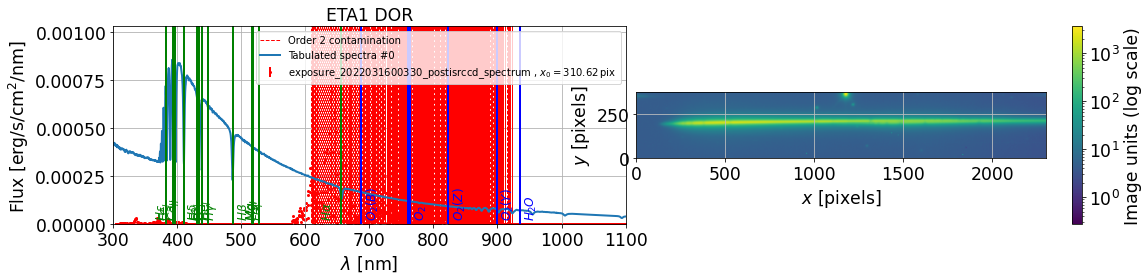

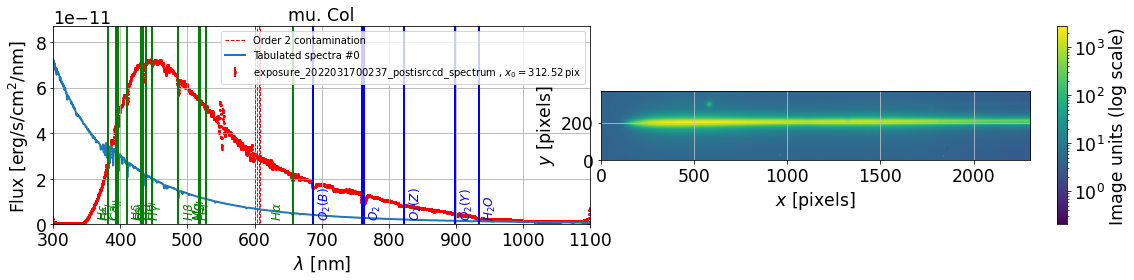

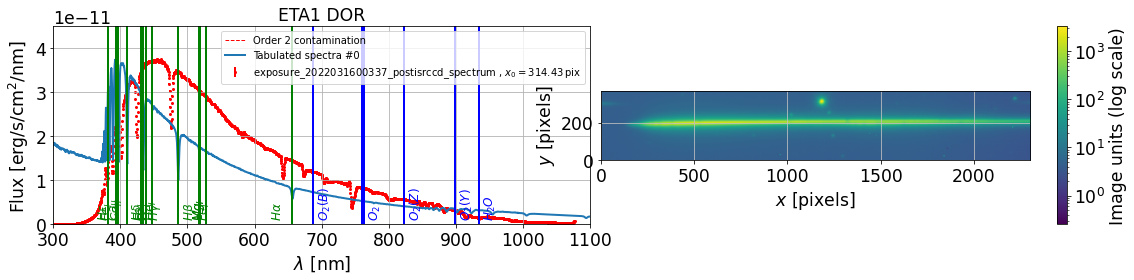

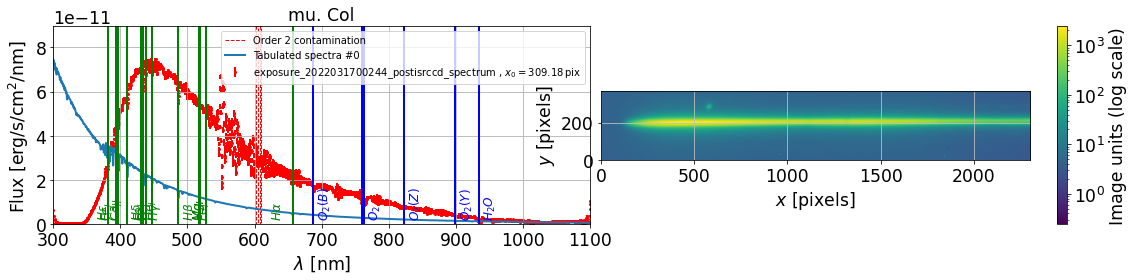

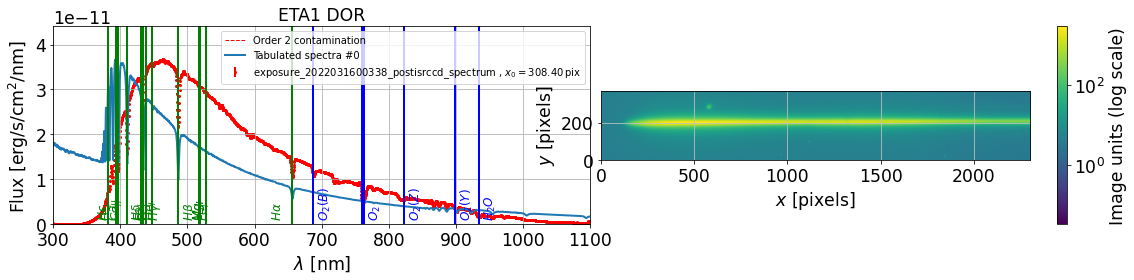

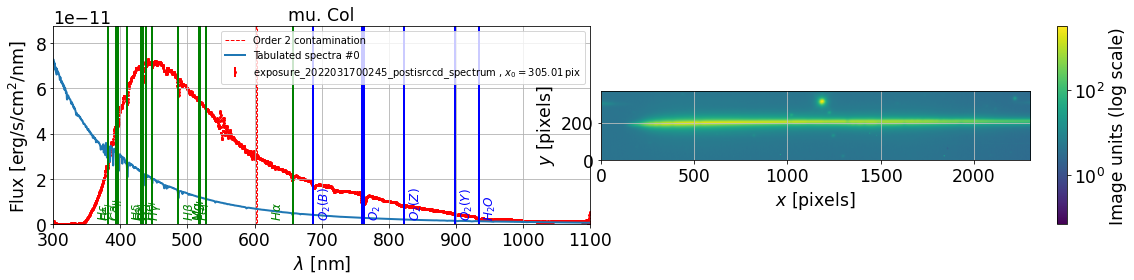

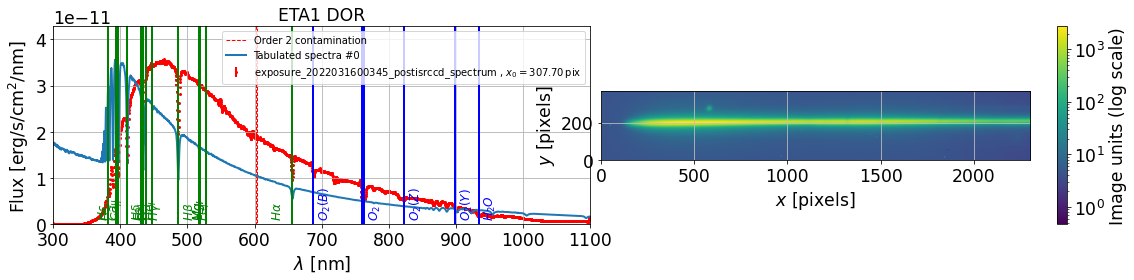

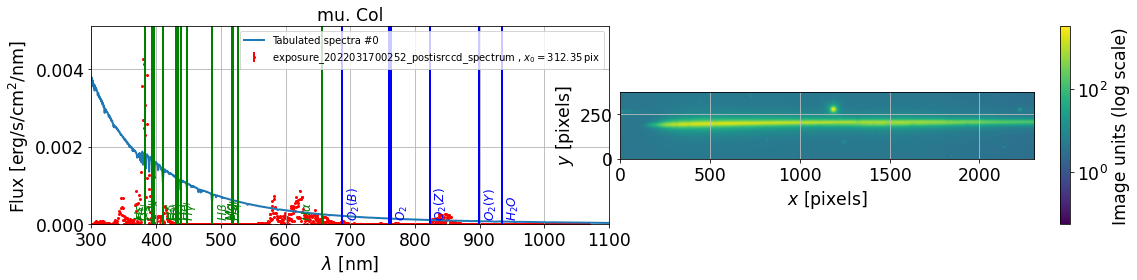

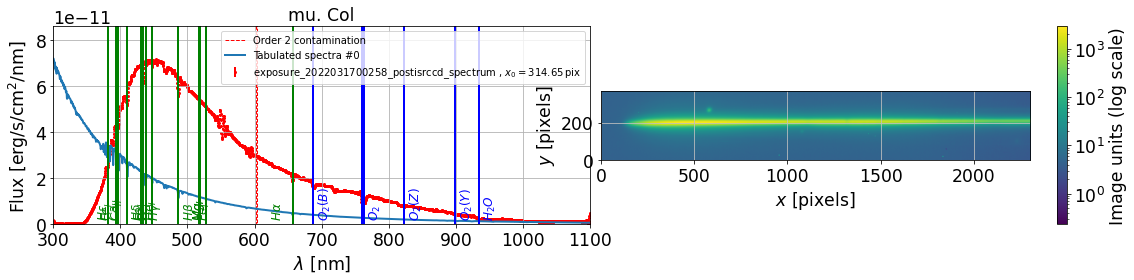

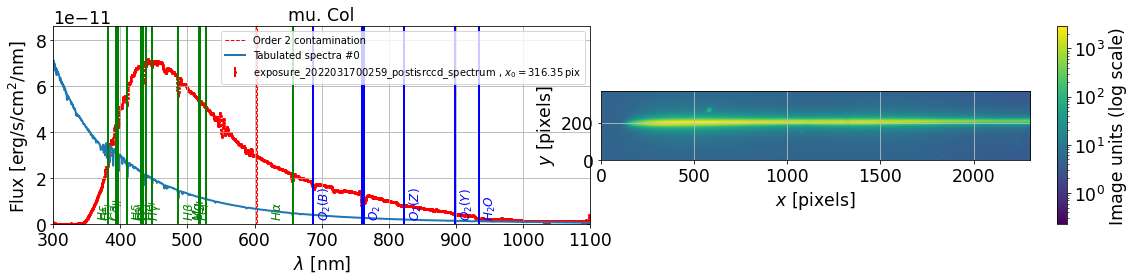

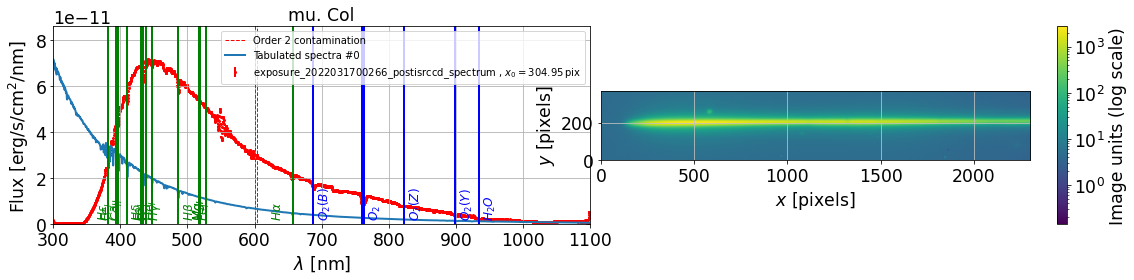

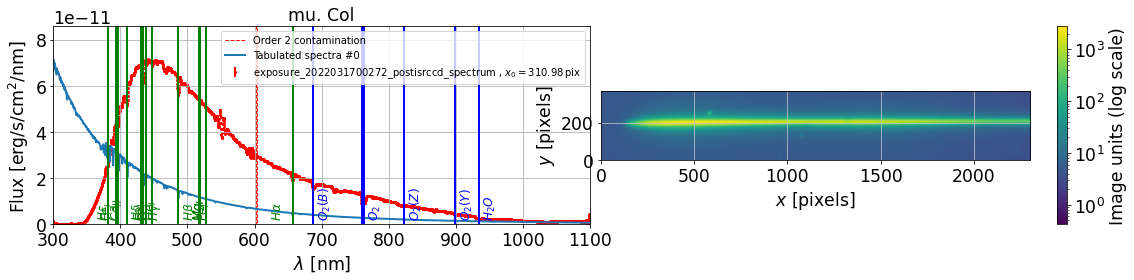

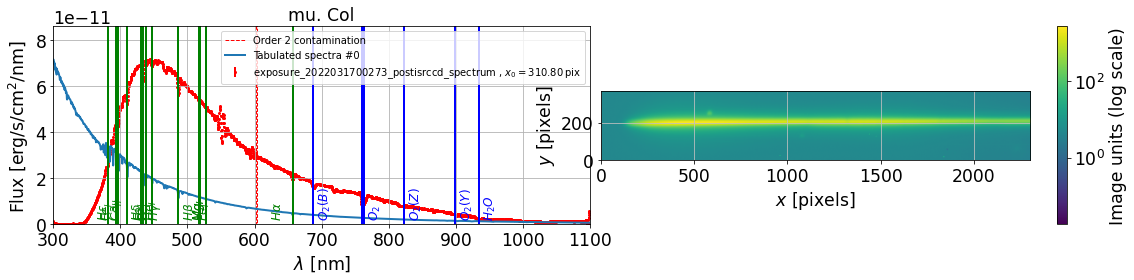

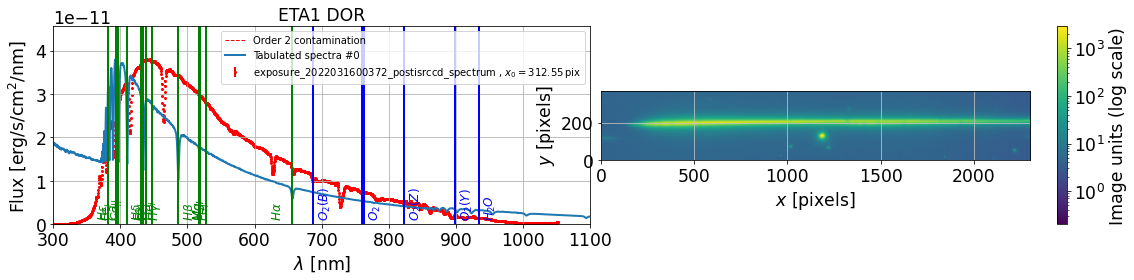

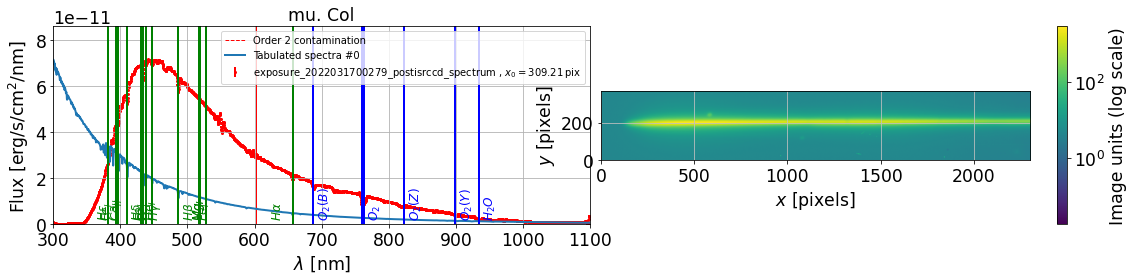

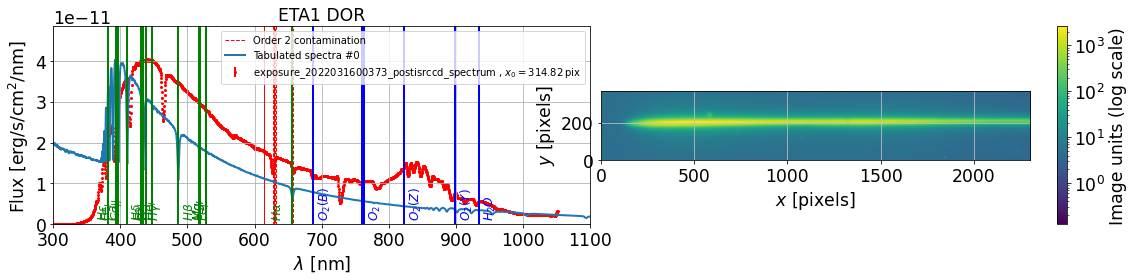

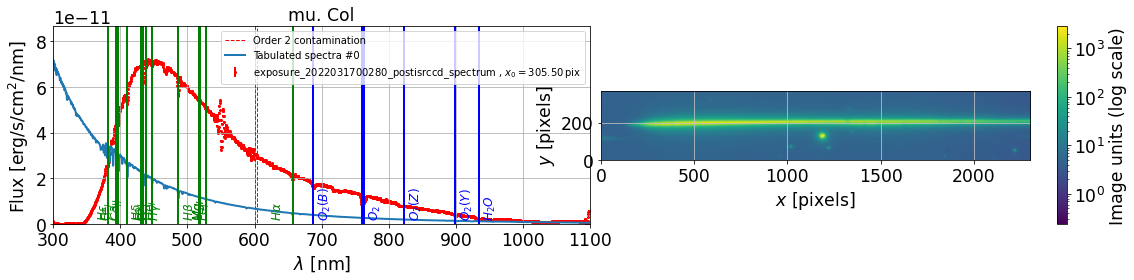

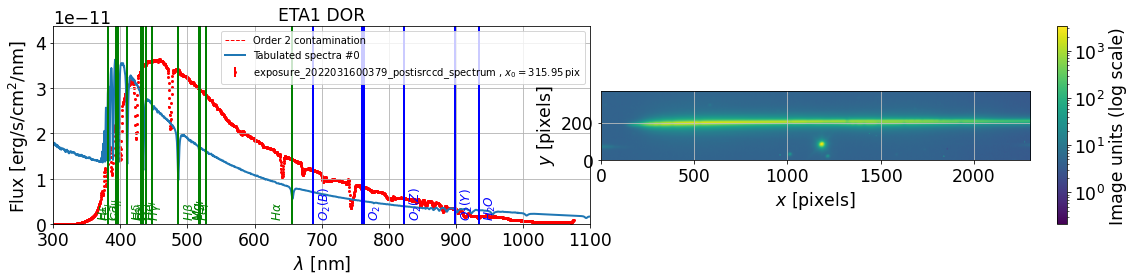

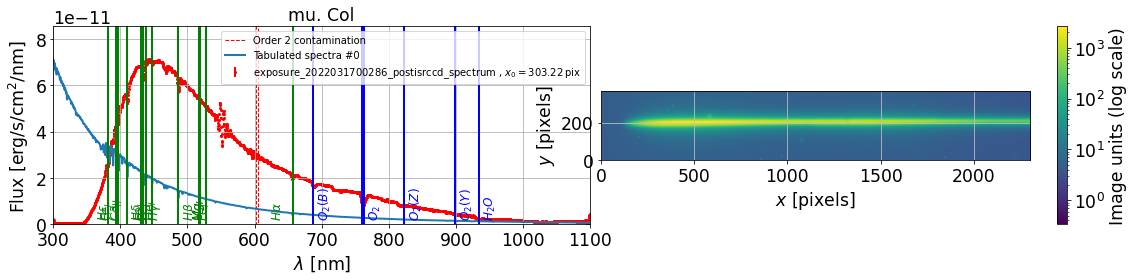

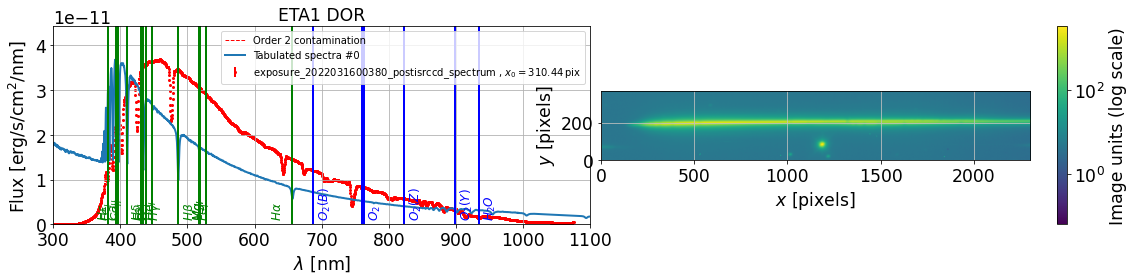

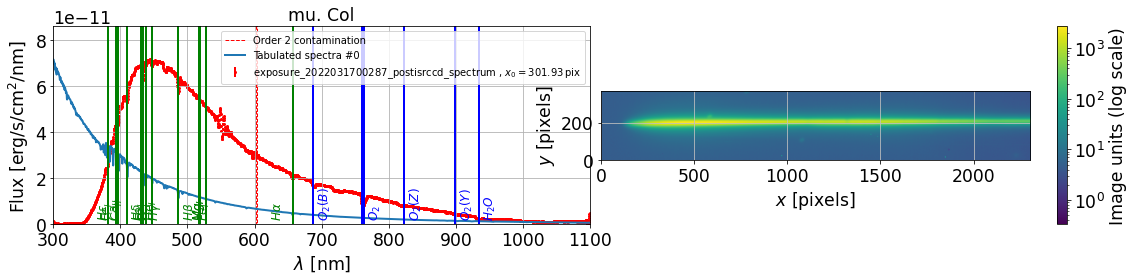

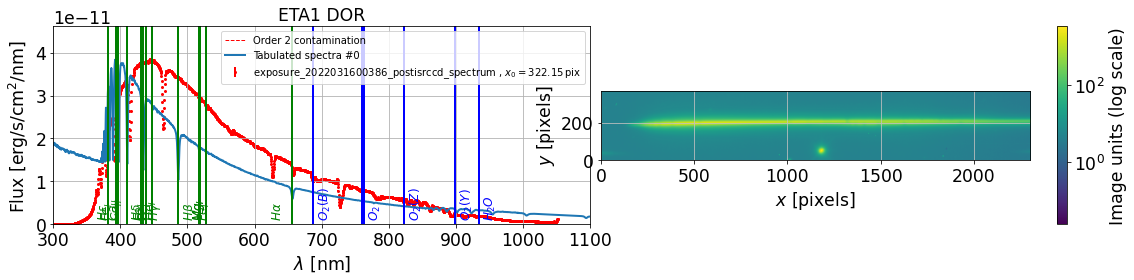

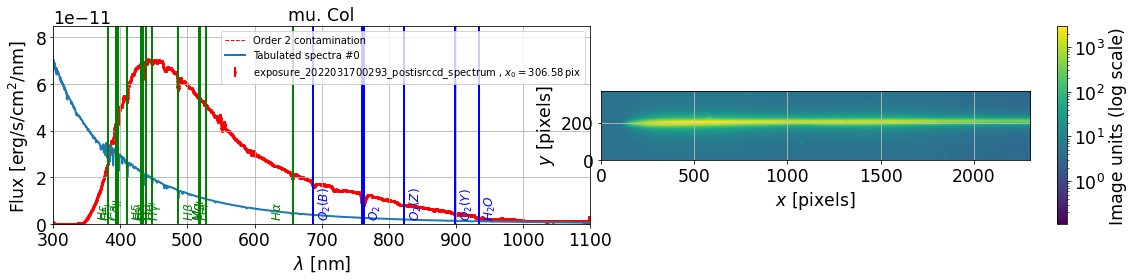

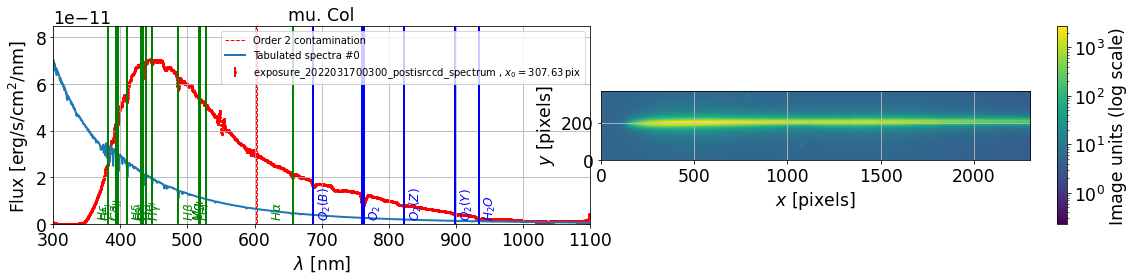

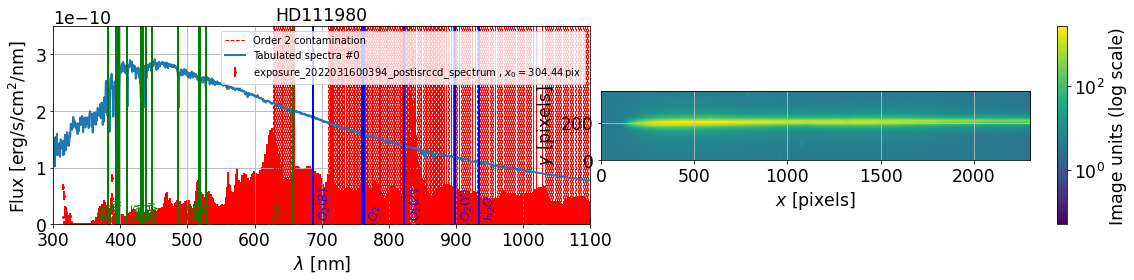

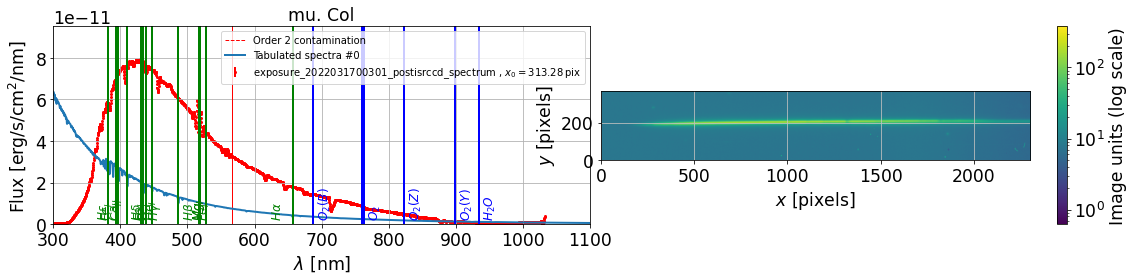

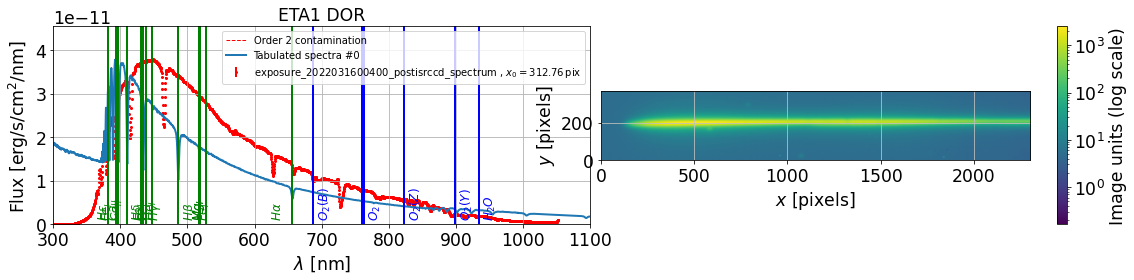

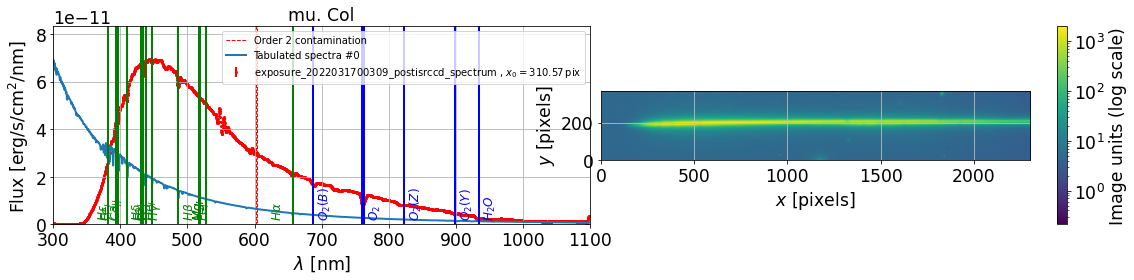

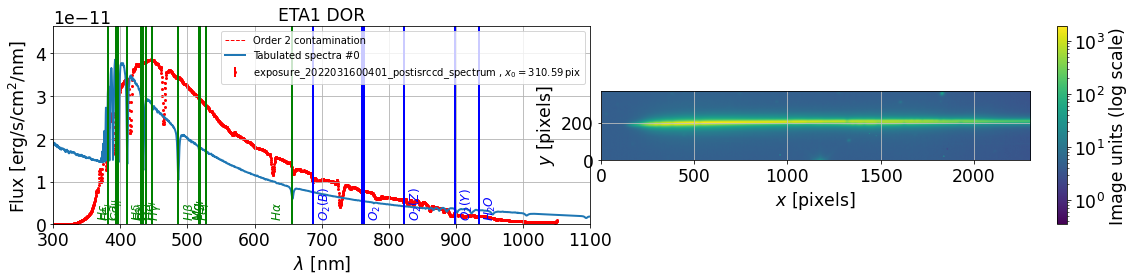

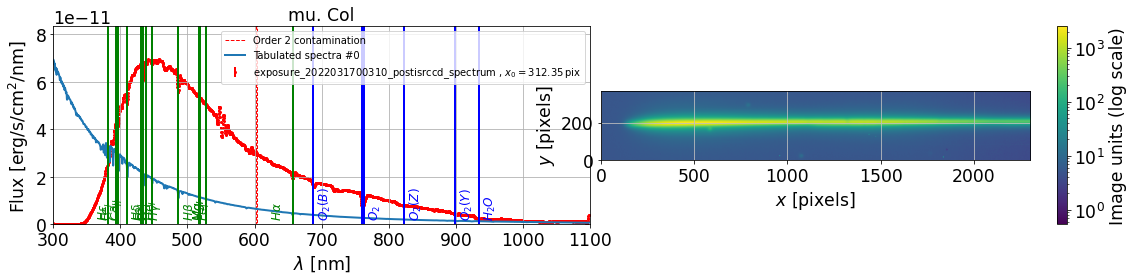

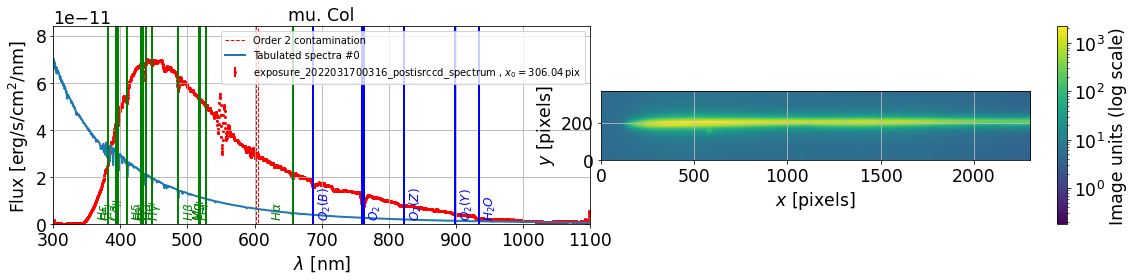

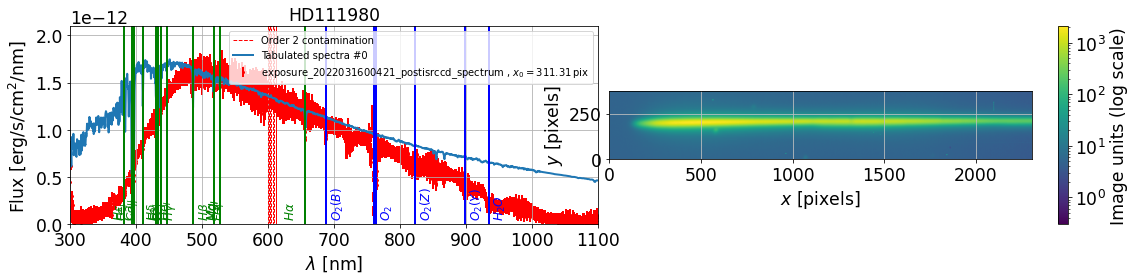

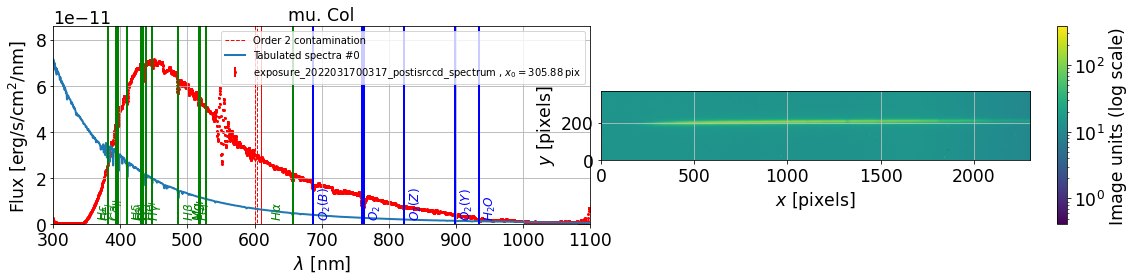

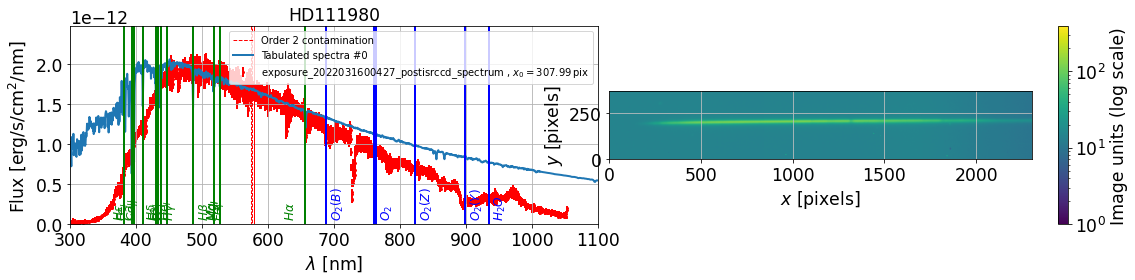

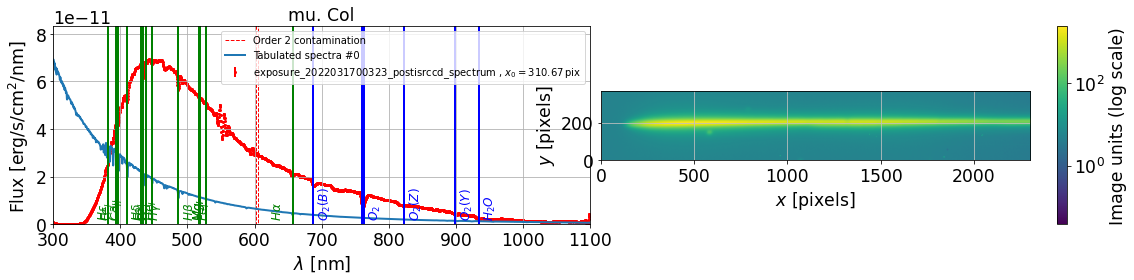

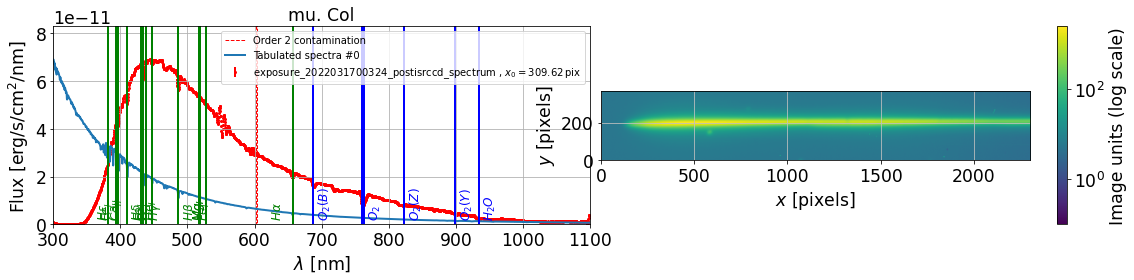

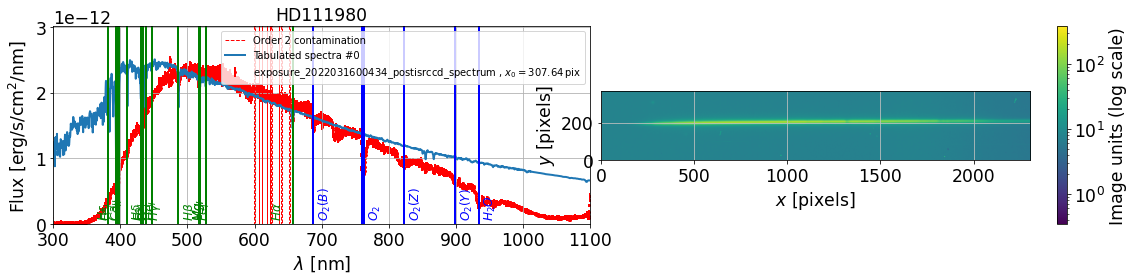

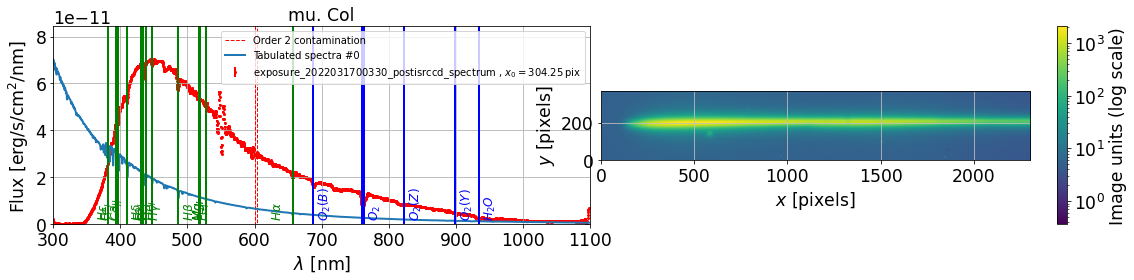

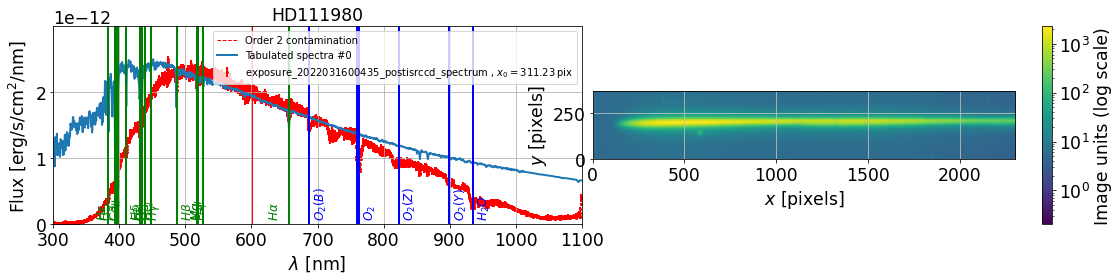

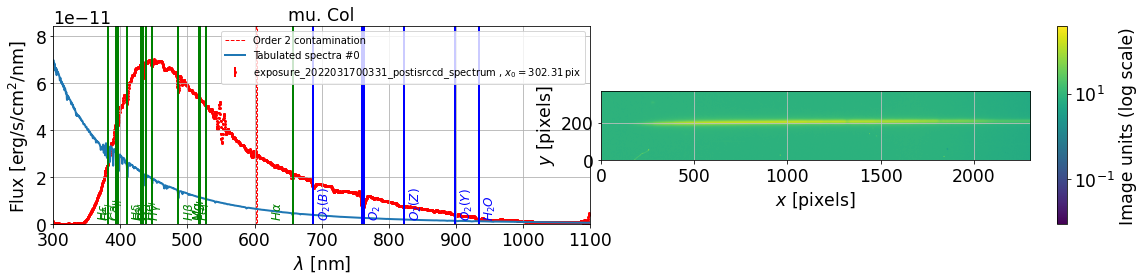

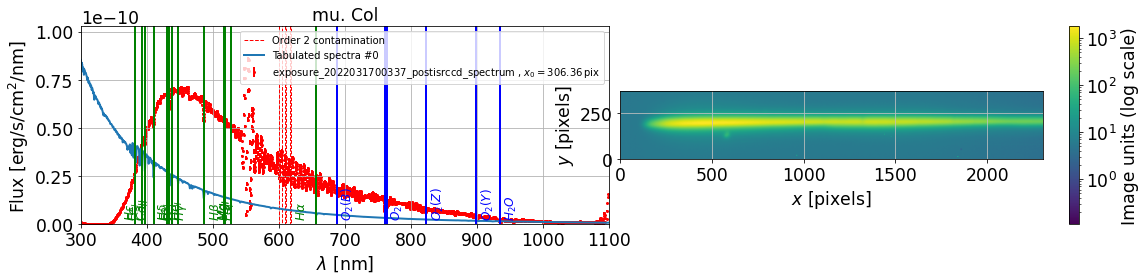

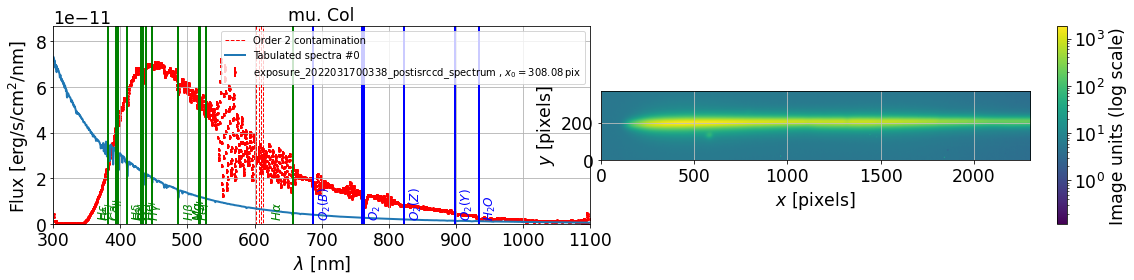

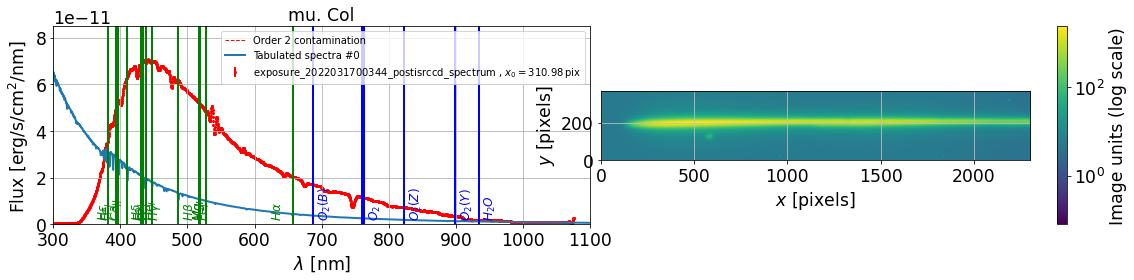

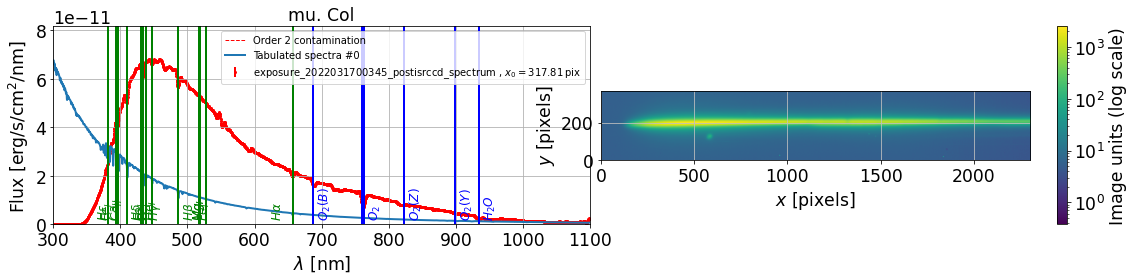

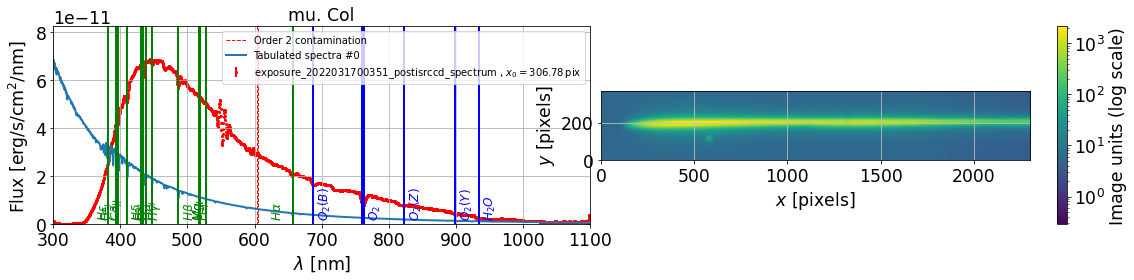

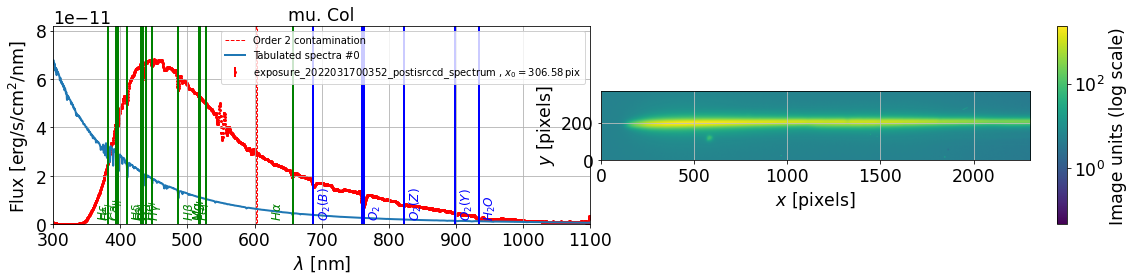

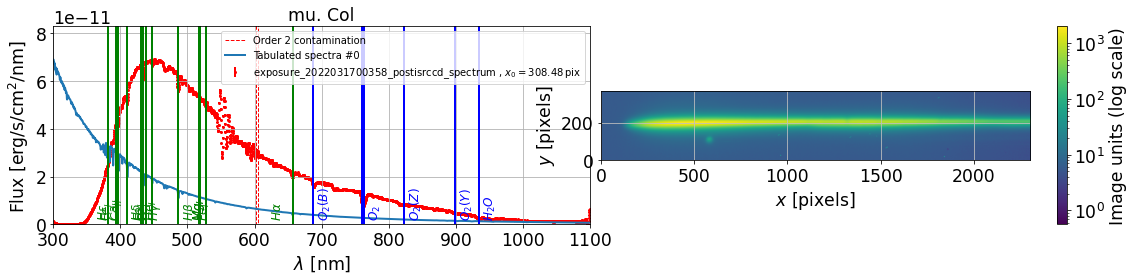

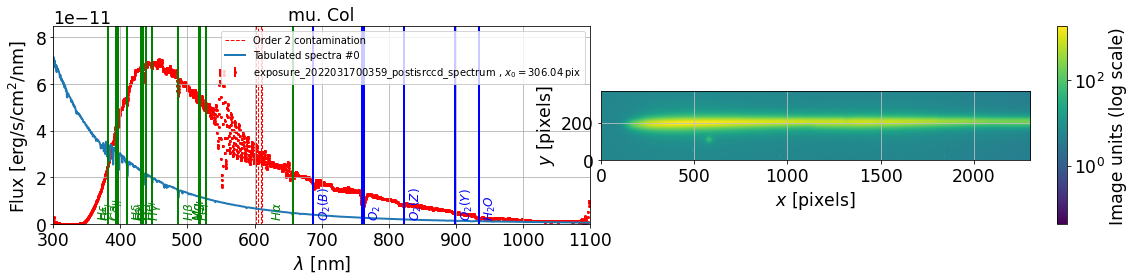

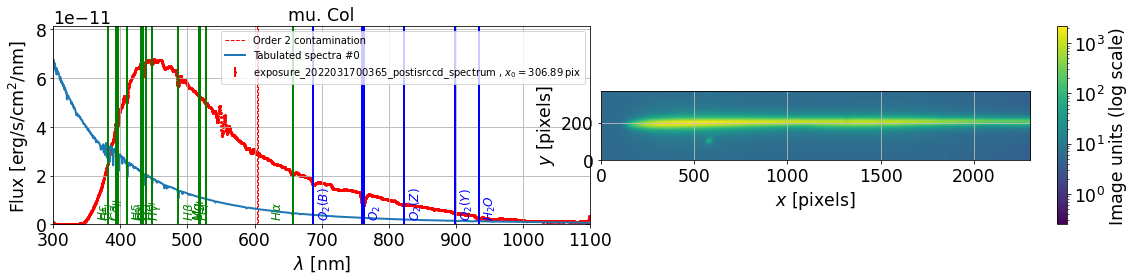

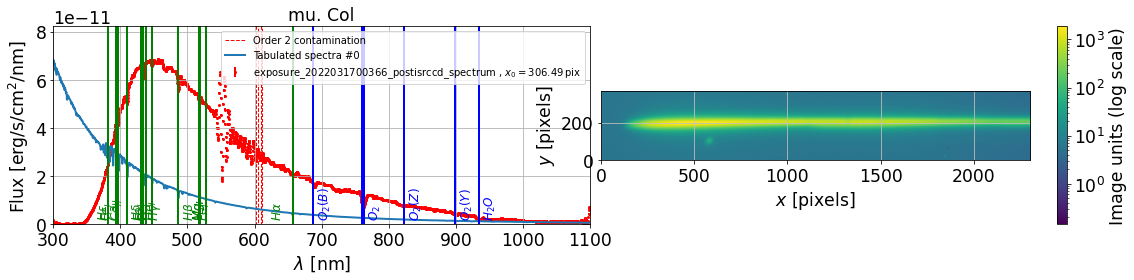

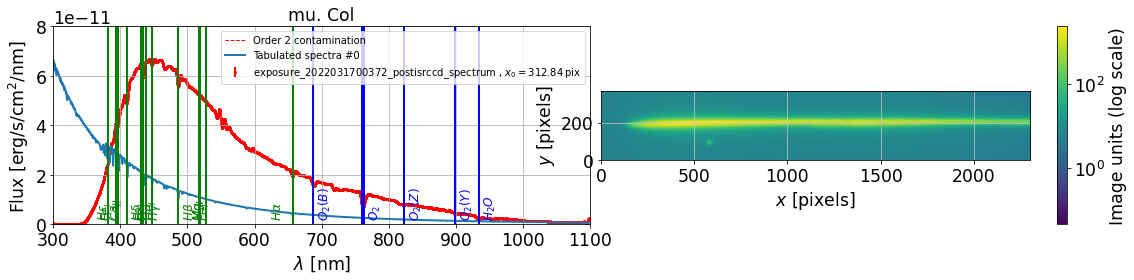

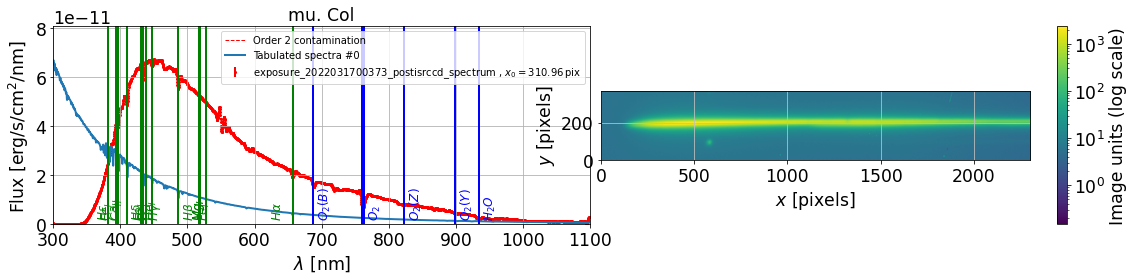

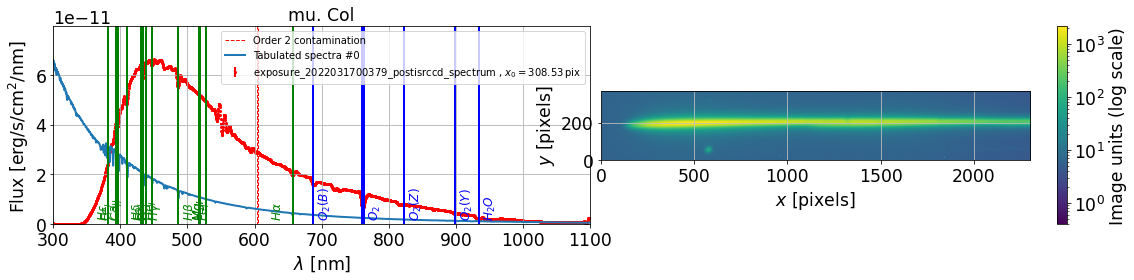

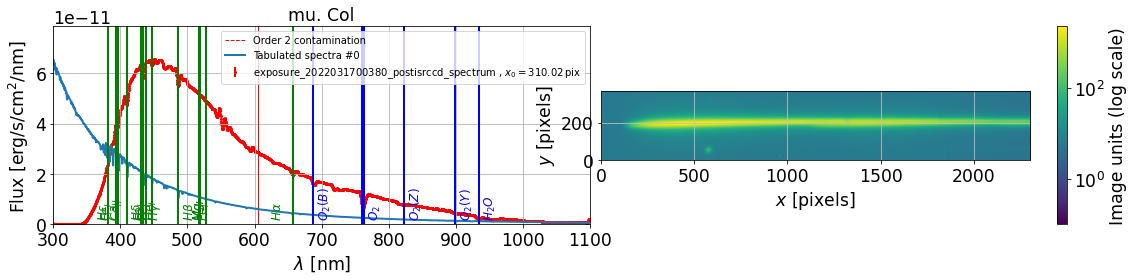

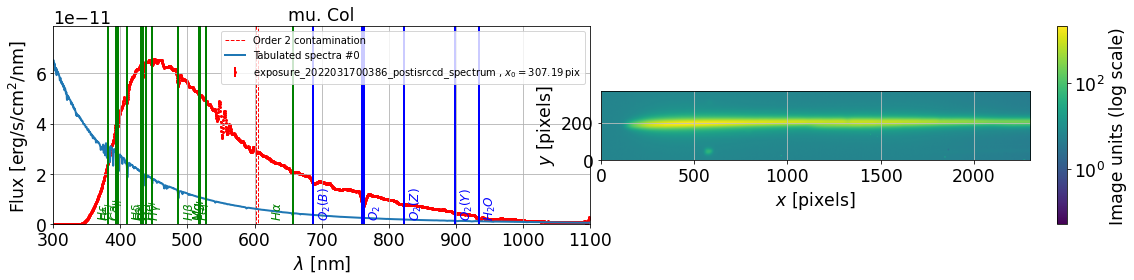

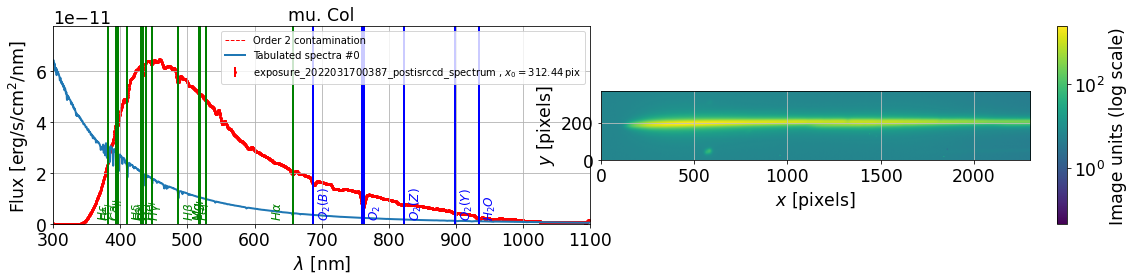

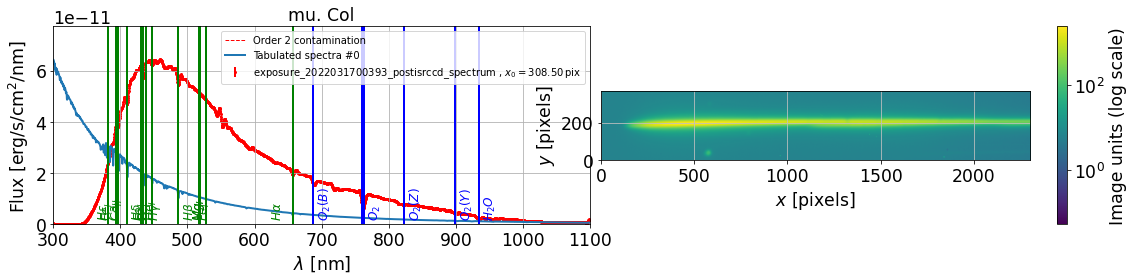

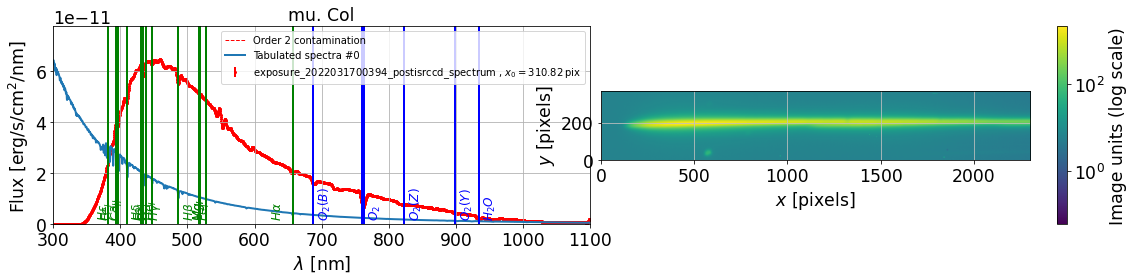

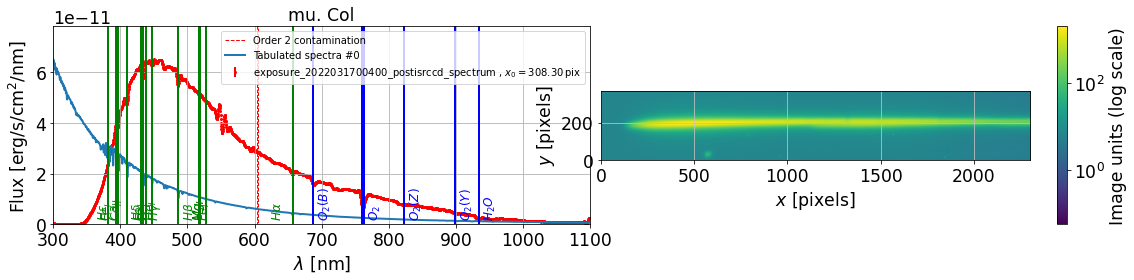

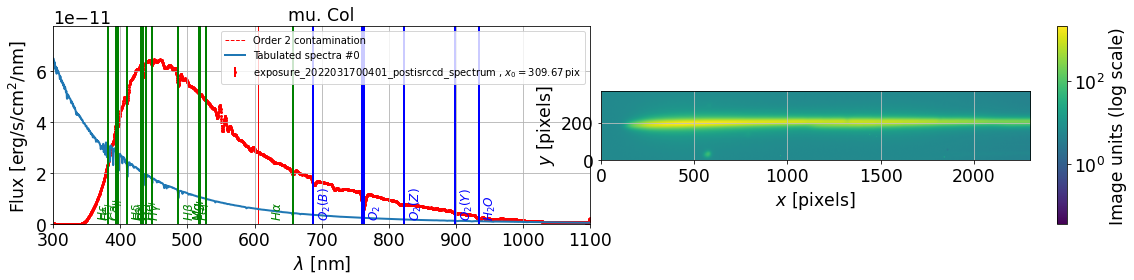

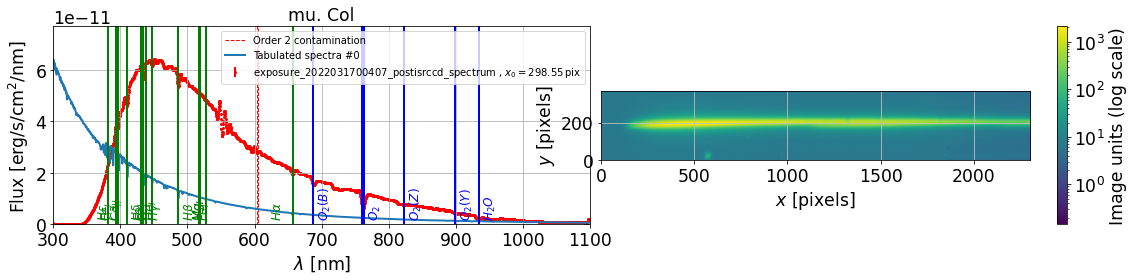

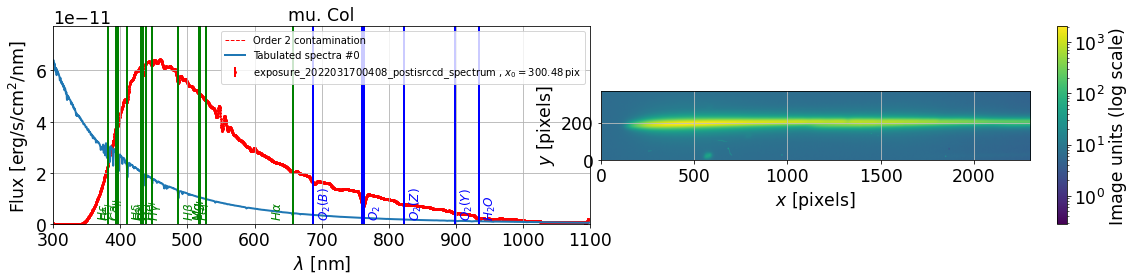

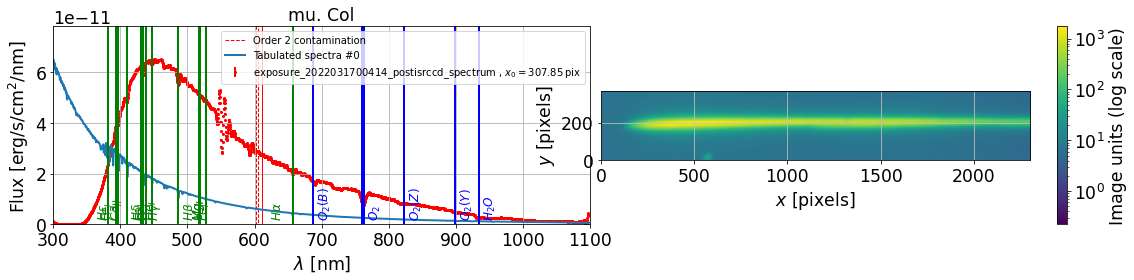

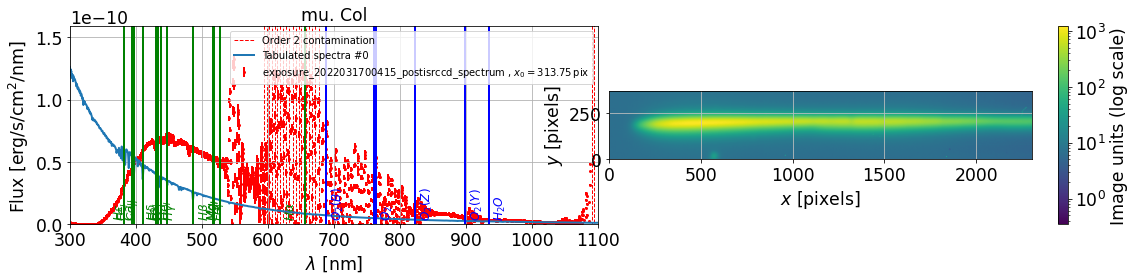

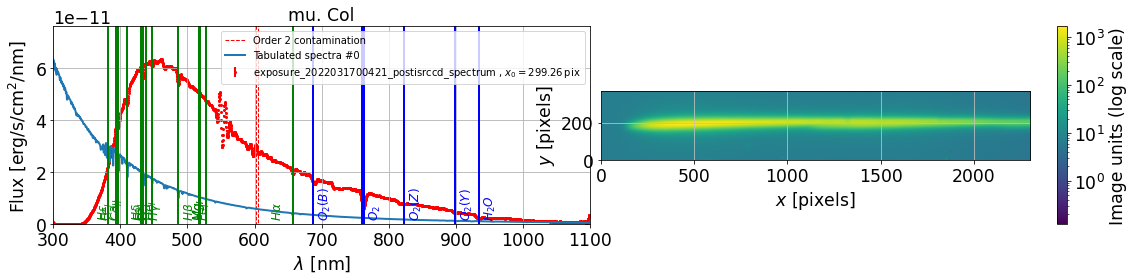

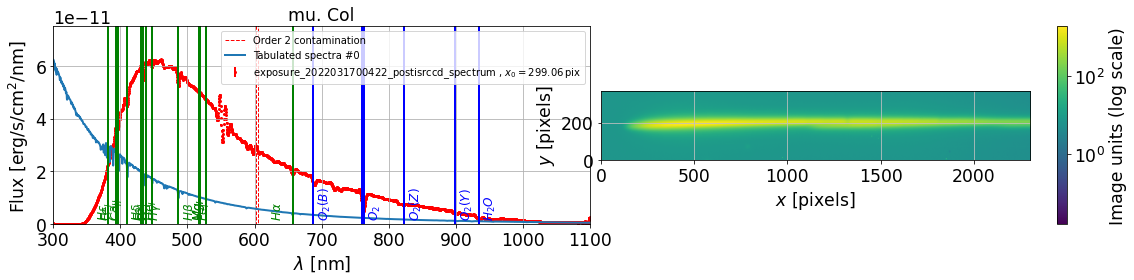

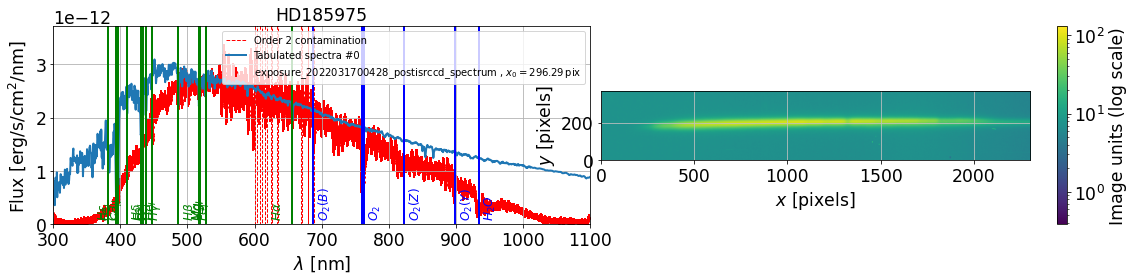

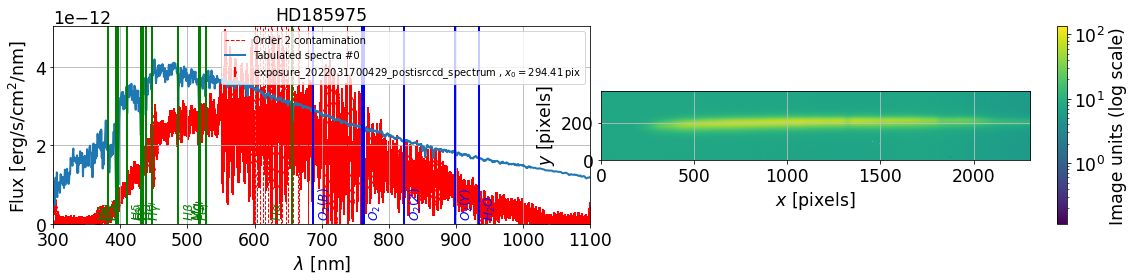

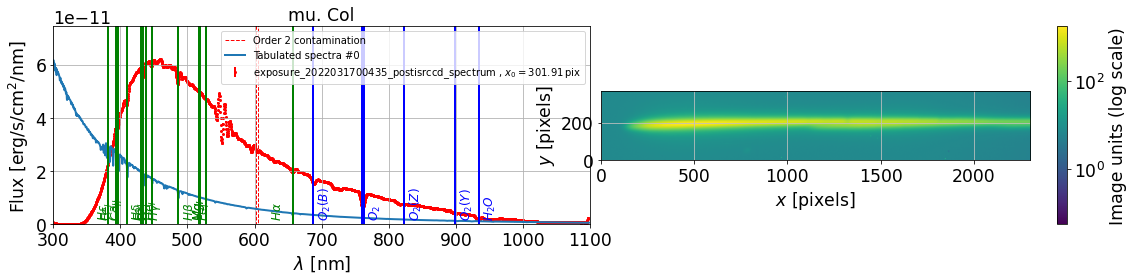

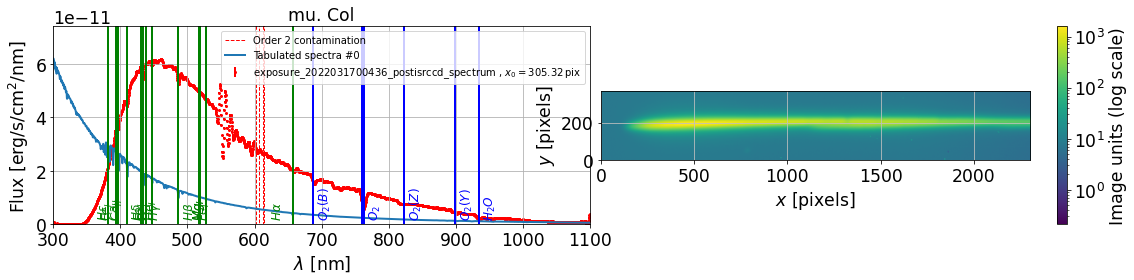

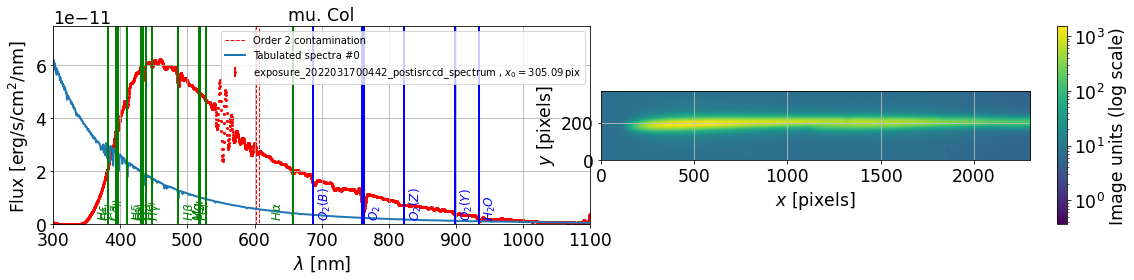

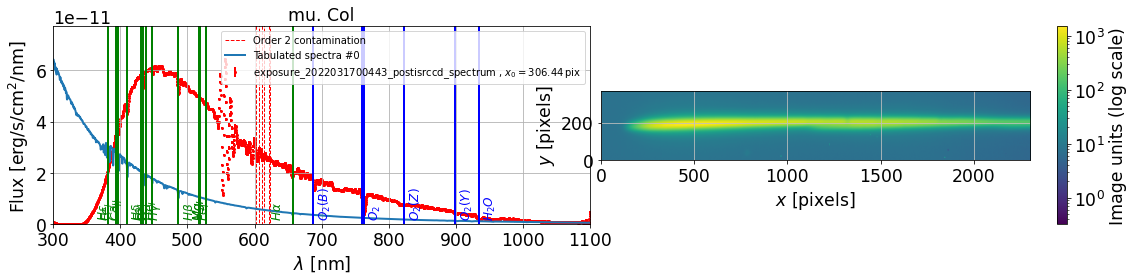

In [51]:
parameters.DISPLAY=True

FLAG_ORDER2 = True

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

## View one spectrum

1 ) exposure_2022031700237_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_PSF2DFFM/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.
set date_obs to 2022-03-18T00:50:48.964
set expo to 20.0
set airmass to 1.11445296512311
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.1930336730012103
set dec to -32.3064444444444
set hour_angle to 30.73762446363224
set temperature to 8.9
set pressure to 743.45
set humidity to 48.0
set lambda_ref to 631.4309539128362
set parallactic_angle to 93.74272252137011
target_name = mu.col, Selected object name for Simbad : mu. Col


2022-06-27 14:45:03  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


 MAIN_ID        RA           DEC      ... Z_VALUE_73 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                            
--------- ------------- ------------- ... ---------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ...  0.0003640                1


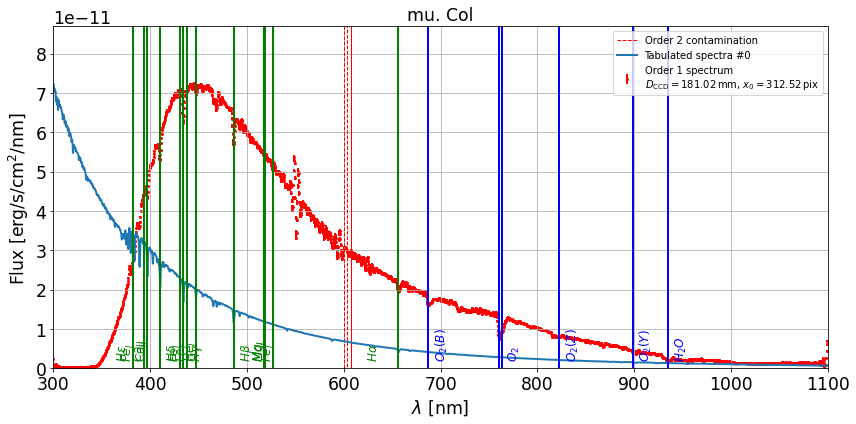

In [52]:
idx=1

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)
    
    
#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    

In [53]:
from spectractor.simulation.adr import adr_calib, flip_and_rotate_adr_to_image_xy_coordinates

In [68]:
parameters.DISPLAY = True
parameters.DEBUG = True
parameters.VERBOSE = True

In [69]:
w = FullForwardModelFitWorkspace(s, verbose=parameters.VERBOSE, plot=True, live_fit=True,
                                         amplitude_priors_method="spectrum")
        

2022-06-27 16:38:17  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=0.1776744582899648.
2022-06-27 16:38:17  Spectrum   convert_from_flam_to_ADUrate WARNING You ask to convert spectrum already in ADU/s in ADU/s... check your code ! Skip the instruction


In [ ]:
spectrum = run_ffm_minimisation(w, method="newton", niter=2)

2022-06-27 16:45:00  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.4246e+07 initial chisq_red=87.26
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.09968049 -0.02065573]
	New parameters: [0.09968049 0.17237794]
	Final cost=9.0389e+06 final chisq_red=55.364 computed in 325.15s
2022-06-27 16:50:19  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=9.0389e+06 initial chisq_red=55.364
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-2.23952787  0.0625737 ]
	New parameters: [-2.13984738  0.23495165]
	Final cost=3.8852e+06 final chisq_red=23.797 computed in 318.73s
2022-06-27 16:55:39  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=2: initial cost=3.8852e+06 initial chisq_red=23.797
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.04696377  0.00180194]
	New parameters: [-2.18681115  0.23675359]
	Final cost=3.8789e+06 final chisq_red=23.758 computed in 319

In [55]:
#w = FullForwardModelFitWorkspace(spectrum=s, amplitude_priors_method="spectrum")

In [56]:
w = FullForwardModelFitWorkspace(spectrum=s ,amplitude_priors_method="fixed", verbose=True)

In [57]:
y, mod, mod_err = w.simulate(*w.p)

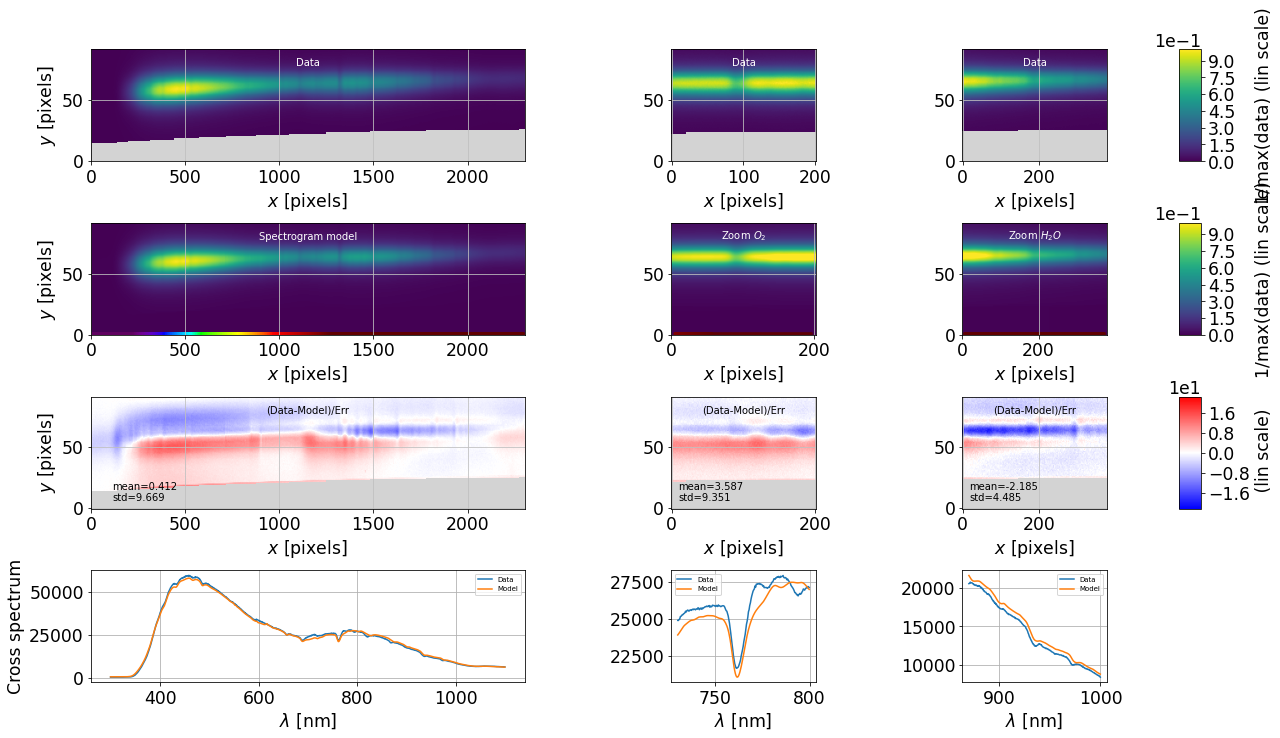

In [58]:
w.plot_fit()

IndexError: index 2 is out of bounds for axis 0 with size 2

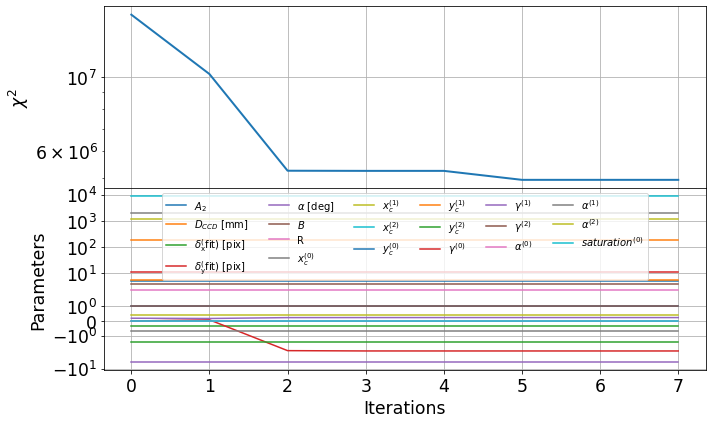

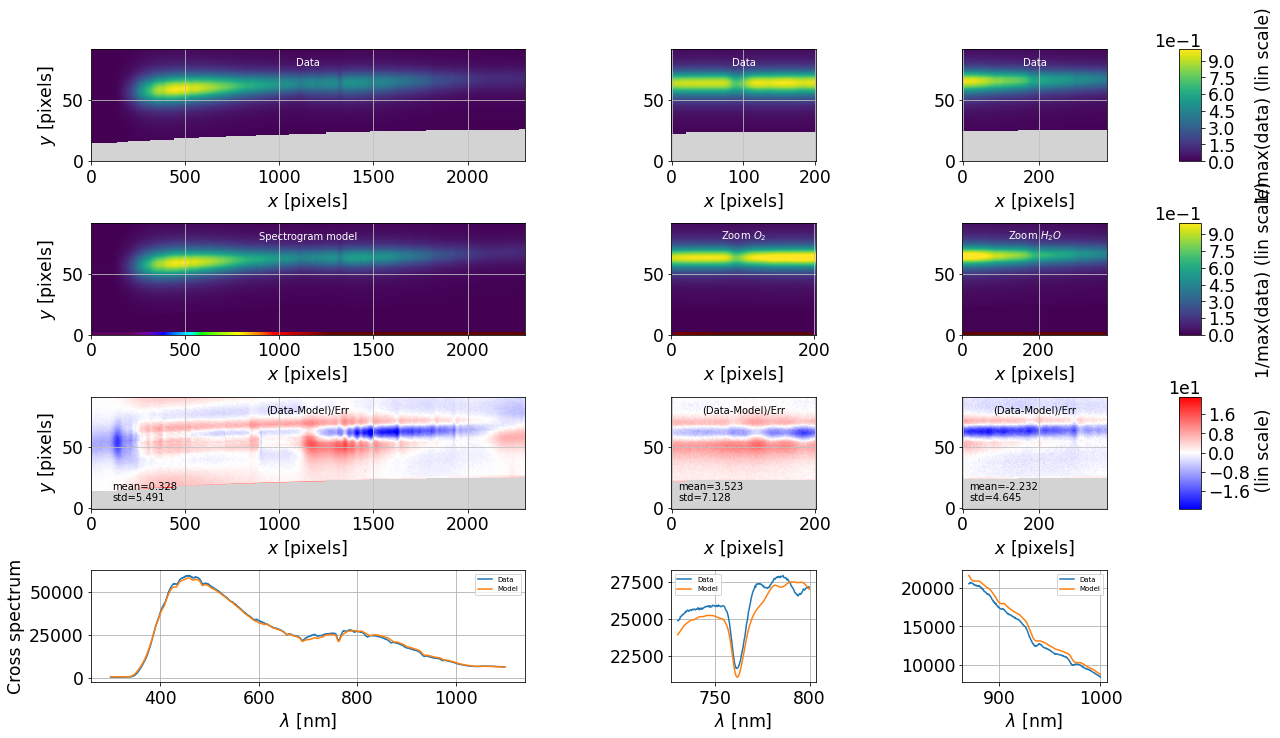

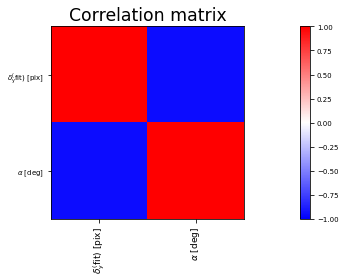

In [60]:
w.adjust_spectrogram_position_parameters()

In [61]:
w = FullForwardModelFitWorkspace(s, verbose=1, plot=True, live_fit=True, amplitude_priors_method="spectrum")

2022-06-27 14:56:26  Spectrum   convert_from_flam_to_ADUrate WARNING You ask to convert spectrum already in ADU/s in ADU/s... check your code ! Skip the instruction


IndexError: index 2 is out of bounds for axis 0 with size 2

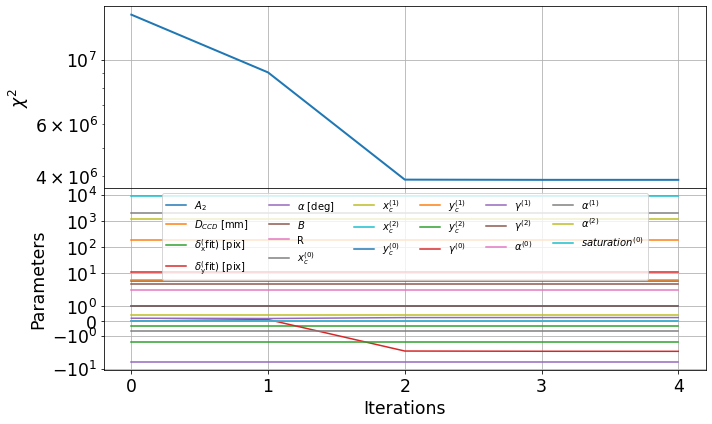

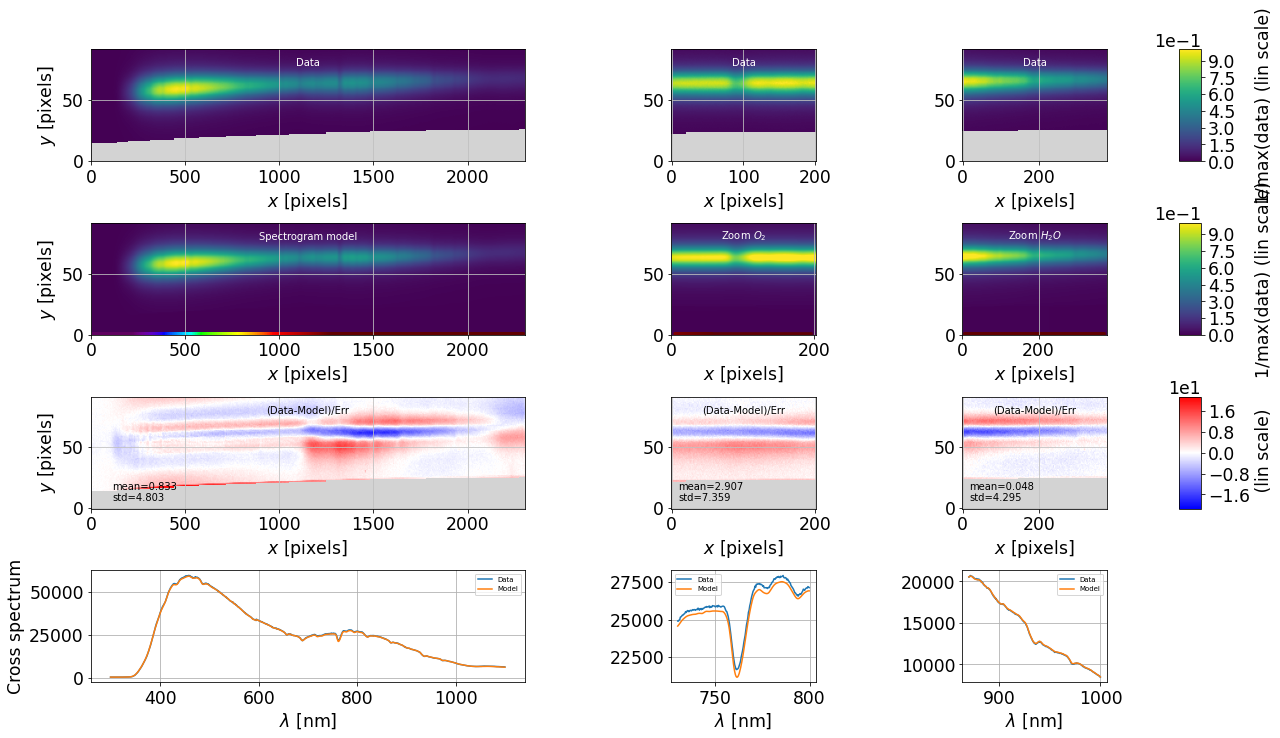

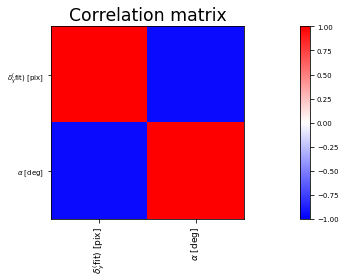

In [64]:
s = run_ffm_minimisation(w, method="newton") 

In [67]:
plot_comparison_truth(s,w)

KeyError: "Keyword 'LBDAS_T' not found."